# Ontology
---

Two key variables will be included: Exposure and Label. 

The variable Exposure will be used to categorize patients based on their dosage of simvastatin, where an exposure value of 1 indicates a low dose and a value of 2 indicates a high dose.

The variable Label will represent the lung cancer outcome, with a value of 0 signifying that the patient did not develop lung cancer and a value of 1 indicating that lung cancer was diagnosed. These variables will be central to the analysis, enabling the investigation of the association between simvastatin dosage and lung cancer development.


Forming the basis:

Response variable is label, part of the feature is the Exposure, along with the rest of the features.

# Question 1: Contingency Table
---

Construct a 2x2 contingency table to examine the relationship between exposure and the outcome. Use this table to calculate basic epidemiological measures, such as odds ratios, and discuss their interpretation in a cohort study.

## Step 0: Install the necessary packages and load them
---

In [147]:
install.packages("dplyr")
install.packages("fastDummies")
install.packages("tableone")
install.packages("MatchIt")
install.packages("survey")  # For weighting analysis
install.packages("cobalt")
install.packages("WeightIt")
install.packages("ggplot2")
install.packages("patchwork")
install.packages("cowplot")
install.packages("caret")
install.packages("car")
install.packages("tibble")
install.packages("corrplot")


The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpF50c7L/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpF50c7L/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpF50c7L/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpF50c7L/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpF50c7L/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpF50c7L/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpF50c7L/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//RtmpF50c7L/downloaded_packages

The downloaded binary packages 

In [69]:
library(dplyr)
library(fastDummies)
library(tableone)
library(MatchIt)
library(survey)
library(cobalt)
library(WeightIt)
library(ggplot2)
library(ggplot2)
library(patchwork)
library(cowplot)
library(caret)
library(car)
library(tibble)
library(corrplot)

## Step 1: Load the dataset
---

In [70]:
load("cleaned_data_with_propensity_score.RData")

## Step 2: Check the content of the data
---

In [71]:
ls()

[1] "Df_regression_unique" "attributable_risk"    "conf_int"            
 [4] "contingency_table"    "cor_matrix"           "exp_coefs"           
 [7] "importance_df"        "importance_df2"       "importance_metrics"  
[10] "importance_metrics2"  "logistic_model"       "logistic_model2"     
[13] "logistic_model3"      "odds_ratio"           "results"             
[16] "risk_exposed"         "risk_ratio"           "risk_unexposed"      
[19] "sorted_df"            "sorted_df2"           "sorted_results"

## Step 3: Check the class of the data
---

In [72]:
class(Df_regression_unique)

[1] "data.frame"

In [73]:
tail(Df_regression_unique)

label age gender_female smoking_status alcohol_assessment bmi  
5933 0     53  1             0              1                  29.66
5934 0     70  0             1              1                  30.06
5935 0     70  0             0              1                  31.07
5936 1     75  0             0              1                  29.60
5937 0     59  0             0              1                  27.30
5938 0     46  1             1              1                  27.60
     chronic_obstructive_bronchitis pneumonia asthma dvt ⋯ no_cancer stage4
5933 0                              0         0      0   ⋯ 1         0     
5934 0                              0         0      0   ⋯ 1         0     
5935 0                              0         0      0   ⋯ 1         0     
5936 0                              0         0      0   ⋯ 1         0     
5937 0                              0         0      0   ⋯ 1         0     
5938 0                              0         0      0   ⋯ 1         0     
     stage1a stage2a stage3a stage1b stage2b stage3b propensity_score weights 
5933 0       0       0       0       0       0       0.01643594       1.016711
5934 0       0       0       0       0       0       0.60717267       2.545648
5935 0       0       0       0       0       0       0.16577225       1.198713
5936 0       0       0       0       0       0       0.40243932       2.484847
5937 0       0       0       0       0       0       0.24174875       1.318824
5938 0       0       0       0       0       0       0.01319190       1.013368

## Step 4: Constructing a 2x2 Contingency Table
---

To examine the relationship between exposure and label, create a 2x2 contingency table using the table() function in R. 


In [74]:
# Create a 2x2 contingency table for exposure and label
contingency_table <- table(Exposure = Df_regression_unique$statin, Label = Df_regression_unique$label)

# Print the contingency table
print(contingency_table)

        Label
Exposure    0    1
       0 3475 1279
       1  764  418


## Step 5: Calculate Basic Epidemiological Measures
---

### Risk:
---

The risk of the outcome (e.g., Label = 1) in each group is calculated as

\begin{equation}
\text{Risk} = \frac{\text{Number of events (Label = 1)}}{\text{Total Number in Group}}
\end{equation}

In [75]:
# Calculate risks
risk_exposed <- contingency_table[2, 2] / sum(contingency_table[2, ])
risk_unexposed <- contingency_table[1, 2] / sum(contingency_table[1, ])

# Print the risks
cat("Risk in exposed group:", risk_exposed, "\n")
cat("Risk in unexposed group:", risk_unexposed, "\n")

Risk in exposed group: 0.3536379 
Risk in unexposed group: 0.2690366 


### Risk Ratio (RR):
---

The risk ratio (RR) compares the risk of the outcome in the exposed group to the unexposed group.

\begin{equation}
\text{RR} = \frac{\text{Risk in Exposed Group}}{\text{Risk in Unexposed Group}}
\end{equation}

In [76]:
# Calculate the risk ratio
risk_ratio <- risk_exposed / risk_unexposed

cat("Risk Ratio (RR):", risk_ratio, "\n")

cat("The exposed group has a", (risk_ratio-1)*100,"% higher risk of the outcome compared to the unexposed group.")

Risk Ratio (RR): 1.31446 
The exposed group has a 31.44602 % higher risk of the outcome compared to the unexposed group.

### Odds Ratio (OR):
---

The odds ratio (OR) compares the odds of the outcome in the exposed group to the unexposed group.

\begin{equation}
\text{OR} = \frac{\text{Number of Exposed (Label = 1)} \times \text{Number of Exposed (Label = 0)}}
{\text{Number of Unexposed (Label = 1)} \times \text{Number of Unexposed (Label = 0)}}
\end{equation}

In [77]:
# Calculate the odds ratio
odds_ratio <- (contingency_table[2, 2] * contingency_table[1, 1]) / 
              (contingency_table[2, 1] * contingency_table[1, 2])

cat("Odds Ratio (OR):", odds_ratio, "\n")

cat("The odds of the outcome are", odds_ratio,"times higher in the exposed group compared to the unexposed group.")

Odds Ratio (OR): 1.486508 
The odds of the outcome are 1.486508 times higher in the exposed group compared to the unexposed group.

### Attributable Risk Difference (ADR):
---

The attributable risk quantifies the excess risk in the exposed group compared to the unexposed group.

\begin{equation}
\text{AR} = \text{Risk in Exposed Group} - \text{Risk in Unexposed Group}
\end{equation}

In [78]:
attributable_risk <- risk_exposed - risk_unexposed

cat("Attributable Risk (AR):", attributable_risk, "\n")


cat("This indicates that", attributable_risk*100," % of the risk in the exposed group is attributable to the exposure.")

Attributable Risk (AR): 0.0846013 
This indicates that 8.46013  % of the risk in the exposed group is attributable to the exposure.

# Question 2: Model Fitting
---

Fit a logistic regression model to investigate the relationship between exposure and outcome, adjusting for other covariates, including the propensity score. Interpret the model's coefficients and their confidence intervals, and discuss their practical significance in the context of the study.

## Step 0: Fit a logistic regression
---

In [79]:
# Fit the logistic regression model
logistic_model  <- glm( `label` ~ `age`+`gender_female`+`smoking_status`+`alcohol_assessment`+`bmi`+`chronic_obstructive_bronchitis`+`pneumonia`+`asthma`+`dvt`+`Followup`+`statin`+`asian`+`white`+`black`+`hawaiian`+`native`+`propensity_score`, 
                        binomial(link = "logit"), 
                        data = Df_regression_unique)

# View the model summary
summary(logistic_model)


Call:
glm(formula = label ~ age + gender_female + smoking_status + 
    alcohol_assessment + bmi + chronic_obstructive_bronchitis + 
    pneumonia + asthma + dvt + Followup + statin + asian + white + 
    black + hawaiian + native + propensity_score, family = binomial(link = "logit"), 
    data = Df_regression_unique)

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -3.196e+00  8.626e-01  -3.705 0.000211 ***
age                             1.112e-02  1.085e-02   1.025 0.305573    
gender_female                  -3.019e-01  1.421e-01  -2.124 0.033640 *  
smoking_status                  5.739e-02  9.603e-02   0.598 0.550085    
alcohol_assessment              1.826e-02  1.073e-01   0.170 0.864849    
bmi                            -3.827e-03  1.843e-02  -0.208 0.835507    
chronic_obstructive_bronchitis -6.657e-01  4.313e-01  -1.543 0.122736    
pneumonia                      -2.239e+00  1.016e+00  -2.204 0.027530 * 

## Step 1: Calculate Odds Ratios and Confidence Intervals
---

The odds ratio (OR) is the exponentiated coefficient and represents the multiplicative change in the odds of the outcome per unit change in the predictor.

In [80]:
# Exponentiate coefficients to calculate odds ratios
exp_coefs <- exp(coef(logistic_model))

# Calculate 95% confidence intervals for odds ratios
conf_int <- exp(confint(logistic_model))

# Combine results into a data frame
results <- data.frame(
  Predictor = names(exp_coefs),
  Odds_Ratio = exp_coefs,
  CI_Lower = conf_int[, 1],
  CI_Upper = conf_int[, 2]
)

# Reset the row names
results <- results %>%
  as_tibble() %>%  # Convert to tibble (no row names)
  as.data.frame()  # Convert back to data frame

print(results)

Waiting for profiling to be done...

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted proba

                        Predictor   Odds_Ratio     CI_Lower     CI_Upper
1                     (Intercept) 4.091081e-02  0.007431813 2.190635e-01
2                             age 1.011183e+00  0.990394953 1.033496e+00
3                   gender_female 7.393990e-01  0.556710761 9.724302e-01
4                  smoking_status 1.059068e+00  0.878775016 1.280786e+00
5              alcohol_assessment 1.018428e+00  0.825203623 1.256822e+00
6                             bmi 9.961807e-01  0.960558255 1.032530e+00
7  chronic_obstructive_bronchitis 5.139371e-01  0.202443092 1.120177e+00
8                       pneumonia 1.065800e-01  0.005985919 4.936524e-01
9                          asthma 2.968452e-06           NA 8.127983e+29
10                            dvt 2.413502e-05           NA 2.192186e+09
11                       Followup 1.000045e+00  0.999900508 1.000195e+00
12                         statin 9.873849e-01  0.825811259 1.179637e+00
13                          asian 1.009608e+00  0.4

### Interpretation:
---
Note: Increased odds of the outcome, indicating residual confounding might exist.

Note: $\text{Percent Changes in Odds} = (\text{Odds Ratio} - 1) \times 100%$
#### 1. Intercept

    - Represents the baseline odds of the outcome when all predictors are zero (not usually interpretable in a meaningful way).

#### 2. Statin (Dose Exposure) 

    Odds ratio: 0.9873 (95% CI: 0.8258-1.1796)
    Interpretation: Small odds ratio (1.27% change) would not be considered practically important, as it suggests minimal to no change in the outcome due.

#### 4. Age

    Odds Ratio: 1.0111 (95% CI: 0.9904-1.0335)
    Interpretation: Small odds ratio (1.11% change) would not be considered practically important, as it suggests minimal to no change in the outcome due.

#### 5. Gender (Female)

    Odds Ratio: 0.7393 (95% CI: 0.5567-0.9724)
    Interpretation: Females have 26.07% less chance of developing lung cancer.
   
#### 6. Smoking Status

    Odds Ratio: 1.0591 (95% CI: 0.8788-1.2808)
    Intepretation: Smoking increases the odds of developing lung cancer by 5.91%.
    
#### 7. Alcohol Assessment

    Odds Ratio: 1.0184 (95% CI: 0.8252-1.256)
    Interpretation: Small odds ratio (1.84% change) would not be considered practically important, as it suggests minimal to no change in the outcome due.

#### 8. Body Mass Index

    Odds Ratio: 0.9961 (95% CI: 0.9605-1.0325)
    Interpretation: Small odds ratio (0.39% change) would not be considered practically important, as it suggests minimal to no change in the outcome due.
 
#### 8. Chronic Obstructive Bronchitis

    Odds Ratio: 0.5139 (95% CI: 0.2024-1.1202)
    Interpretation: Those diagnoes with chronic obstructive bronchitis has a reduced odds of developing lung cancer by 48.61%. (I think because they have regular follow ups with the pulmonologists so they are routinely checked).
    
#### 8. Pneumonia

    Odds Ratio: 0.1065 (95% CI: 0.0060-0.4937)
    Interpretation: Those diagnoes with pneumonia has a reduced odds of developing lung cancer by 89.35%. (I think because they have regular follow ups with the pulmonologists so they are routinely checked).
    
#### 8. Asthma

    Odds Ratio: 2.9685e-06 (95% CI: NA-38.12798e+29)
    Interpretation: Those diagnosed with asthma has a very low odds of developing lung cancer. (I think because they have regular follow ups with the pulmonologists so they are routinely checked).

#### 8. Acute Deep Venous Thrombosis (DVT)

    Odds Ratio: 2.4135e-05 (95% CI: NA-2.1922e+09)
    Interpretation: Those diagnosed with DVT has a very low odds of developing lung cancer. (I think becausethey are routinely checked by a medical professional).
    
#### 9. Follow up

    Odds Ratio: 1.0001 (95% CI: 0.9999-1.0002)
    Interpretation: Small odds ratio would not be considered practically important, as it suggests minimal to no change in the outcome due to the exposure.

#### 10. Asian

    Odds Ratio: 1.0100 (95% CI: 0.4991-2.1364)
    Interpretation: Small odds ratio would not be considered practically important, as it suggests minimal to no change in the outcome due to the exposure.
    Statistical Note: A very wide 95% confidence interval (CI) indicates significant uncertainty in the estimate of the effect size (e.g., the odds ratio).

#### 11. White

    Odds Ratio: 1.0004 (95% CI: 0.5143-2.0466)
    Interpretation: Small odds ratio would not be considered practically important, as it suggests minimal to no change in the outcome due to the exposure.
    Statistical Note: A very wide 95% confidence interval (CI) indicates significant uncertainty in the estimate of the effect size (e.g., the odds ratio).

#### 12. Black

    Odds Ratio: 0.9703 (95% CI 0.4796-2.055)
    Interpretation: Small odds ratio would not be considered practically important, as it suggests minimal to no change in the outcome due to the exposure.
    Statistical Note: A very wide 95% confidence interval (CI) indicates significant uncertainty in the estimate of the effect size (e.g., the odds ratio).


#### 13. Hawaiian

    Odds Ratio: 0.9423 (95% CI 0.3387-2.5657)
    Interpretation: Hawaiian descent has a decreased odds of developing lung cancer by 5.77%.
    Statistical Note: A very wide 95% confidence interval (CI) indicates significant uncertainty in the estimate of the effect size (e.g., the odds ratio).

#### 14. Native

    Odds Ratio: 0.4197 (95% CI 0.0220-2.4402)
    Interpretation: Individuals in the exposed group have a 58.03% reduced odds of experiencing the outcome compared to the unexposed group, adjusting for other covariates.
    Statistical Note: A very wide 95% confidence interval (CI) indicates significant uncertainty in the estimate of the effect size (e.g., the odds ratio).
    
#### 15. Propensity Score

    Odds ratio: 128.9793 (95% CI: 36.2151–439.9992)
    Interpretation: A unit increase of propensity score greatly increases the odds of developing lung cancer.
    Statistical Note: A very wide 95% confidence interval (CI) indicates significant uncertainty in the estimate of the effect size (e.g., the odds ratio).

# Question 3: Variable Importance in Logistic Regression
---

Train a logistic regression model and assess the importance of individual variables in predicting the outcome. Reflect on how variable importance is used in model interpretation and decision-making, particularly in epidemiological research.

## Step 0: Examine Coefficients
---

The summary of the logistic model includes coefficients for each variable. Variables with larger absolute coefficients (or statistically significant p-values) are typically more important predictors.

### Interpretation:
---

1. Coefficients: Indicate the direction and strength of the association between each predictor and the outcome.

2. p-values: Test whether the coefficient for each variable is significantly different from zero.

In [81]:
# View the model summary
summary(logistic_model)


Call:
glm(formula = label ~ age + gender_female + smoking_status + 
    alcohol_assessment + bmi + chronic_obstructive_bronchitis + 
    pneumonia + asthma + dvt + Followup + statin + asian + white + 
    black + hawaiian + native + propensity_score, family = binomial(link = "logit"), 
    data = Df_regression_unique)

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -3.196e+00  8.626e-01  -3.705 0.000211 ***
age                             1.112e-02  1.085e-02   1.025 0.305573    
gender_female                  -3.019e-01  1.421e-01  -2.124 0.033640 *  
smoking_status                  5.739e-02  9.603e-02   0.598 0.550085    
alcohol_assessment              1.826e-02  1.073e-01   0.170 0.864849    
bmi                            -3.827e-03  1.843e-02  -0.208 0.835507    
chronic_obstructive_bronchitis -6.657e-01  4.313e-01  -1.543 0.122736    
pneumonia                      -2.239e+00  1.016e+00  -2.204 0.027530 * 

## Step 1: Convert the coefficients into odds ratios to make them easier to interpret.
---

### Interpretation
---

1. Odds Ratios > 1: Increase in the odds of the outcome.

2. Odds Ratios < 1: Decrease in the odds of the outcome.

3. Confidence Intervals: Reflect the precision of the odds ratio estimates.

In [82]:
print(results)

                        Predictor   Odds_Ratio     CI_Lower     CI_Upper
1                     (Intercept) 4.091081e-02  0.007431813 2.190635e-01
2                             age 1.011183e+00  0.990394953 1.033496e+00
3                   gender_female 7.393990e-01  0.556710761 9.724302e-01
4                  smoking_status 1.059068e+00  0.878775016 1.280786e+00
5              alcohol_assessment 1.018428e+00  0.825203623 1.256822e+00
6                             bmi 9.961807e-01  0.960558255 1.032530e+00
7  chronic_obstructive_bronchitis 5.139371e-01  0.202443092 1.120177e+00
8                       pneumonia 1.065800e-01  0.005985919 4.936524e-01
9                          asthma 2.968452e-06           NA 8.127983e+29
10                            dvt 2.413502e-05           NA 2.192186e+09
11                       Followup 1.000045e+00  0.999900508 1.000195e+00
12                         statin 9.873849e-01  0.825811259 1.179637e+00
13                          asian 1.009608e+00  0.4

In [83]:
# Rank the variables based on highest odds ratio
sorted_results <- results[order(-results$Odds_Ratio), ]
print(sorted_results)

                        Predictor   Odds_Ratio     CI_Lower     CI_Upper
18               propensity_score 1.289793e+02 36.215107492 4.399992e+02
4                  smoking_status 1.059068e+00  0.878775016 1.280786e+00
5              alcohol_assessment 1.018428e+00  0.825203623 1.256822e+00
2                             age 1.011183e+00  0.990394953 1.033496e+00
13                          asian 1.009608e+00  0.499074159 2.136405e+00
14                          white 1.000408e+00  0.514309044 2.046621e+00
11                       Followup 1.000045e+00  0.999900508 1.000195e+00
6                             bmi 9.961807e-01  0.960558255 1.032530e+00
12                         statin 9.873849e-01  0.825811259 1.179637e+00
15                          black 9.703257e-01  0.479544683 2.054698e+00
16                       hawaiian 9.423790e-01  0.338742672 2.565665e+00
3                   gender_female 7.393990e-01  0.556710761 9.724302e-01
7  chronic_obstructive_bronchitis 5.139371e-01  0.2

## Step 2: Use Variable Importance Metrics
---
You can use the caret package to compute variable importance based on the model coefficients.

### Interpretation
---

Variables with higher importance scores contribute more to the prediction of the outcome.

In [84]:
# Compute variable importance
importance_metrics <- varImp(logistic_model, scale = FALSE)
# Convert to data frame if it is not already one
importance_df <- as.data.frame(importance_metrics)
# Transform row names to a new column named "Index" and reset row names
importance_df <- rownames_to_column(importance_df, var = "Features")
# Sort by a specific column in ascending order
sorted_df <- importance_df[order(-importance_df$Overall), ]
print(sorted_df)

                         Features     Overall
17               propensity_score 7.635203028
7                       pneumonia 2.203925952
2                   gender_female 2.124356802
6  chronic_obstructive_bronchitis 1.543390574
1                             age 1.024554384
16                         native 0.797090972
10                       Followup 0.600175768
3                  smoking_status 0.597632886
5                             bmi 0.207644142
4              alcohol_assessment 0.170204927
11                         statin 0.139591968
15                       hawaiian 0.115506062
14                          black 0.081479306
9                             dvt 0.055904837
12                          asian 0.025879376
8                          asthma 0.017883742
13                          white 0.001162931


## Step 3: Check for Multicollinearity
---

1. Multicollinearity can inflate the importance of correlated variables. Use variance inflation factors (VIF) to check for multicollinearity.

2. The Variance Inflation Factor (VIF) is a measure of multicollinearity among independent variables in a regression model. In the context of a logistic regression model, vif(logistic_model) assesses how much the variance of a regression coefficient is inflated due to multicollinearity.

3. The VIF for a variable $X_{i}$ is calculated as:
\begin{equation}
VIF(X_{i})=\frac{1}{1-R_{i}ˆ{2}}
\end{equation}

Where $R_{i}ˆ{2}$ is the $Rˆ{2}$ value from regressing $X_{i}$ on all other predictors.

4. Interpretation of VIF Values:

    VIF = 1: No correlation between the variable and other predictors (no multicollinearity).

    1 < VIF ≤ 5: Moderate correlation that is generally acceptable.
    
    VIF > 5: High correlation; the variable may be problematic and contribute to multicollinearity.
    
    VIF > 10: Severe multicollinearity, and the variable is likely inflating the variance of the regression coefficients significantly.

5. Practical Implications:

    High VIF values indicate redundancy among predictors, making it difficult to isolate the effect of individual variables on the outcome.

In [85]:
vif(logistic_model)

age                  gender_female 
                      5.157066                       2.453980 
                smoking_status             alcohol_assessment 
                      2.027810                       1.655451 
                           bmi chronic_obstructive_bronchitis 
                      1.047137                       1.212742 
                     pneumonia                         asthma 
                      1.022204                       1.000000 
                           dvt                       Followup 
                      1.000028                       4.836977 
                        statin                          asian 
                      1.255184                       8.502268 
                         white                          black 
                     15.513750                       8.622236 
                      hawaiian                         native 
                      1.870809                       1.134796 
              propensity_score 
                     14.252087

## Step 4: Check correlations
---

If there are large VIF values, better check correlation matrix and drop correlated variables.

In [86]:
cor(Df_regression_unique[, c('age','gender_female','smoking_status','alcohol_assessment','bmi','chronic_obstructive_bronchitis'
                             ,'pneumonia','asthma','dvt','Followup','statin','asian','white','black','hawaiian','native','propensity_score')])

age          gender_female smoking_status
age                             1.000000000 -0.417538948   0.0064968495 
gender_female                  -0.417538948  1.000000000  -0.0152493680 
smoking_status                  0.006496850 -0.015249368   1.0000000000 
alcohol_assessment             -0.147380197  0.159440510  -0.0088298494 
bmi                            -0.121363629  0.080956967  -0.0004100898 
chronic_obstructive_bronchitis -0.014428791  0.041001723   0.1216165304 
pneumonia                      -0.066078971  0.056820886  -0.0229399999 
asthma                         -0.018514062  0.024445046  -0.0221346524 
dvt                            -0.034680035  0.028000055  -0.0196475412 
Followup                        0.063443296 -0.084718319   0.0049005297 
statin                         -0.019749899 -0.110381318  -0.0345313694 
asian                           0.000131101  0.012254100  -0.0127703942 
white                          -0.007407236 -0.021937593   0.0231149340 
black                           0.015634998  0.010793500  -0.0109777693 
hawaiian                       -0.010741756  0.018878267  -0.0076732730 
native                         -0.008824201  0.001200125  -0.0088797639 
propensity_score                0.663465589 -0.592524482   0.1905835352 
                               alcohol_assessment bmi          
age                            -0.147380197       -0.1213636287
gender_female                   0.159440510        0.0809569674
smoking_status                 -0.008829849       -0.0004100898
alcohol_assessment              1.000000000        0.0308816267
bmi                             0.030881627        1.0000000000
chronic_obstructive_bronchitis  0.023708914       -0.0064194222
pneumonia                       0.016251110       -0.0003507735
asthma                          0.011828334       -0.0142359183
dvt                             0.021354795       -0.0005302708
Followup                       -0.054197040        0.0012443822
statin                         -0.026719595       -0.0223251720
asian                           0.032752836       -0.0029027444
white                          -0.025737807       -0.0190039362
black                           0.001431550        0.0277797392
hawaiian                        0.001383870        0.0101291364
native                          0.005287875       -0.0120704388
propensity_score               -0.328389229       -0.1312090684
                               chronic_obstructive_bronchitis pneumonia    
age                            -0.014428791                   -0.0660789706
gender_female                   0.041001723                    0.0568208858
smoking_status                  0.121616530                   -0.0229399999
alcohol_assessment              0.023708914                    0.0162511099
bmi                            -0.006419422                   -0.0003507735
chronic_obstructive_bronchitis  1.000000000                   -0.0083226142
pneumonia                      -0.008322614                    1.0000000000
asthma                         -0.004035796                   -0.0046182793
dvt                            -0.003683461                    0.5487247954
Followup                       -0.022656637                   -0.0276645464
statin                         -0.016338401                    0.0214343829
asian                          -0.006210516                    0.0088660704
white                          -0.006993660                    0.0056551055
black                           0.009440966                   -0.0217439821
hawaiian                       -0.004606764                    0.0113358998
native                          0.037906374                    0.0020181777
propensity_score               -0.163979742                   -0.2230512462
                               asthma       dvt           Followup     
age                            -0.018514062 -0.0346800348  0.0634432964
gender_female                   0.024445046  0.028000

## Step 5: Plot an upper triangle matrix for easier visualization
---

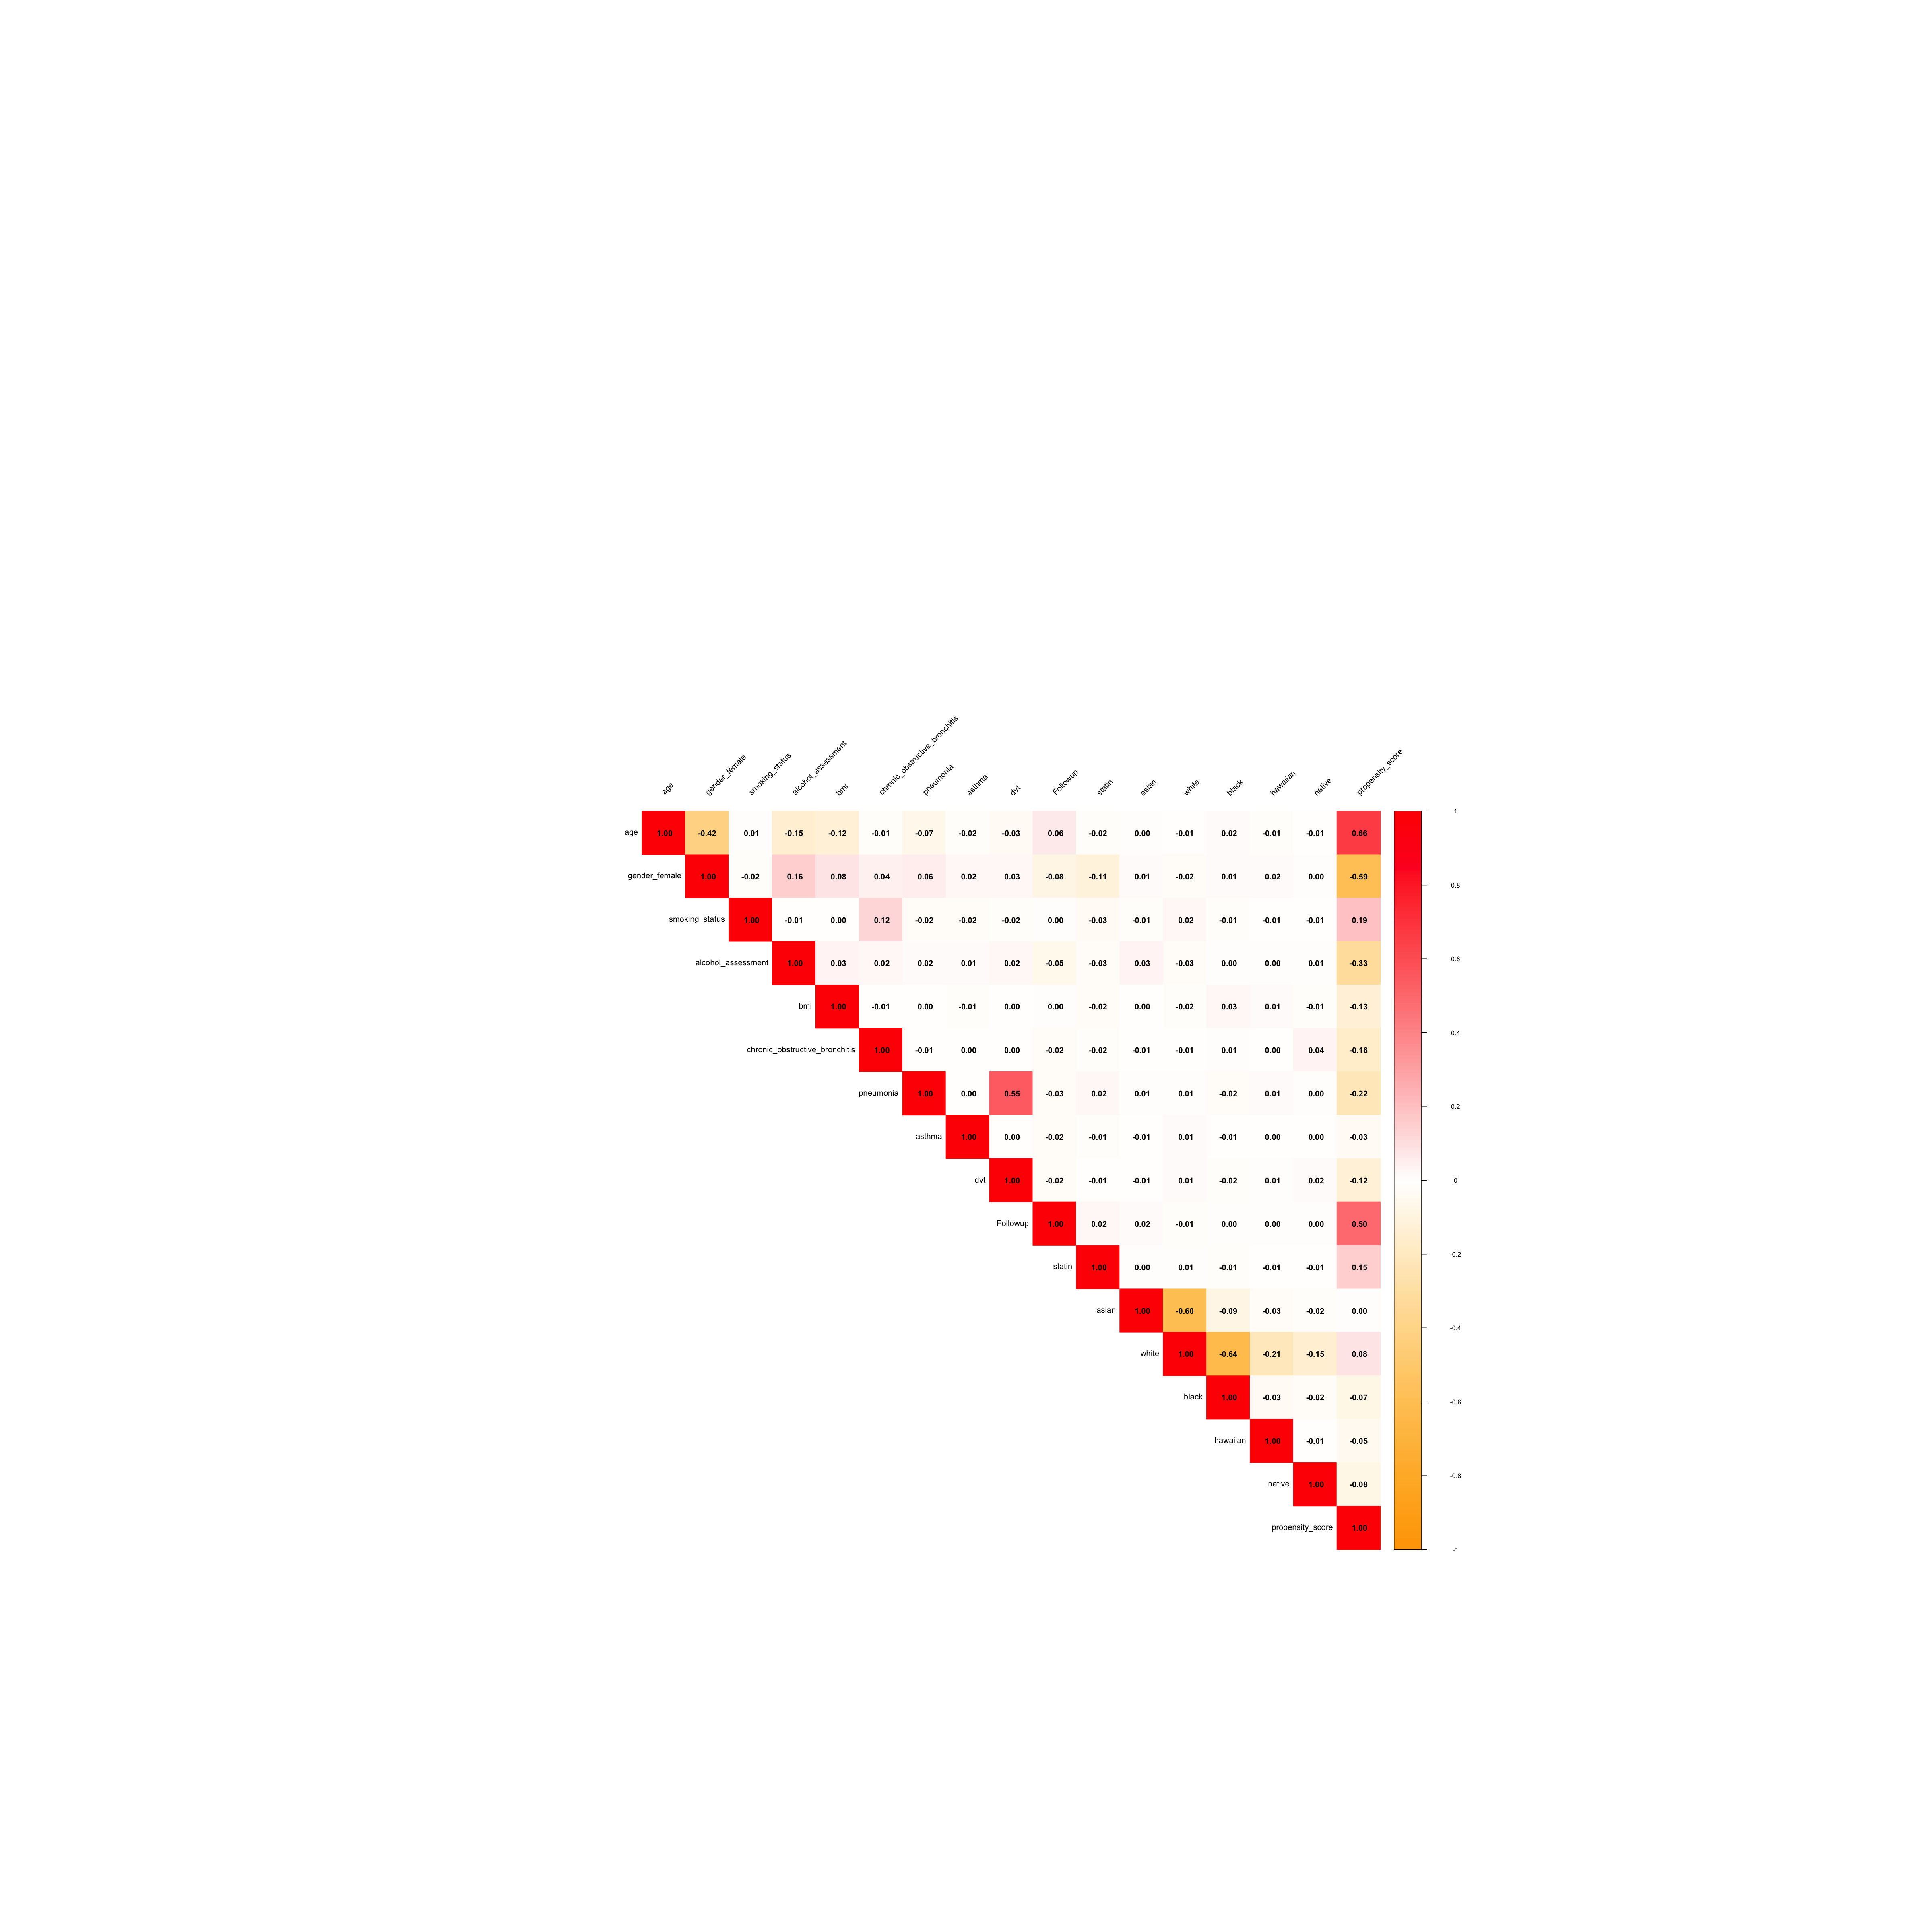

In [87]:
# Compute the correlation matrix
# Resize display for interactive use
options(repr.plot.width = 40, repr.plot.height = 40)

cor_matrix <- cor(Df_regression_unique[, c('age','gender_female','smoking_status','alcohol_assessment','bmi','chronic_obstructive_bronchitis'
                             ,'pneumonia','asthma','dvt','Followup','statin','asian','white','black','hawaiian','native','propensity_score')])

# Visualize the correlation matrix with colors
corrplot(cor_matrix, method = "color", 
         col = colorRampPalette(c("orange", "white", "red"))(200),
         type = "upper",  # Show only the upper triangle
         addCoef.col = "black",  # Add correlation coefficients
         tl.col = "black",       # Color of text labels
         tl.srt = 45)            # Rotate text labels

png("correlation_plot_high_res.png", width = 1200, height = 800, res = 300)
# please see the png file since the graph here is very small

## Step 6: Variable Selection or Model Replacement (?)
---

In the correlation matrix, all of the highly important features are correlated, and therefore logistic regression might not be the best model to perform prediction tasks. If the researcher want to include correlated variables into the prediction process then models that makes no assumptions to the relationship between features should be used, such as decision trees or other ensembled methods. Tree based models split features based on impurity measures,hence if two variables are heavily correlated, then no or little information can be gained from splitting on X2 after X1 has been split.

## Step 7: Redo the logistic regression
---

1. Remove variables with high VIF.

2. Reperform feature importance.

In [88]:
# refit the logistic regression model
# Note that I am keeping: Age even since its VIF is just a fraction higher than 5 (5.1571)

logistic_model2 <- glm( `label` ~ `age`+`gender_female`+`smoking_status`+`alcohol_assessment`+`bmi`+`chronic_obstructive_bronchitis`+`pneumonia`+`asthma`+`dvt`+`Followup`+`statin`+`hawaiian`+`native`, 
                        binomial(link = "logit"), 
                        data = Df_regression_unique)

# View the model summary
summary(logistic_model2)


Call:
glm(formula = label ~ age + gender_female + smoking_status + 
    alcohol_assessment + bmi + chronic_obstructive_bronchitis + 
    pneumonia + asthma + dvt + Followup + statin + hawaiian + 
    native, family = binomial(link = "logit"), data = Df_regression_unique)

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -6.650e+00  6.633e-01 -10.026  < 2e-16 ***
age                             8.813e-02  5.224e-03  16.870  < 2e-16 ***
gender_female                  -1.172e+00  9.567e-02 -12.250  < 2e-16 ***
smoking_status                  5.994e-01  6.714e-02   8.926  < 2e-16 ***
alcohol_assessment             -4.858e-01  8.210e-02  -5.918 3.26e-09 ***
bmi                            -3.228e-02  1.801e-02  -1.792 0.073150 .  
chronic_obstructive_bronchitis -2.227e+00  4.015e-01  -5.548 2.89e-08 ***
pneumonia                      -3.694e+00  1.009e+00  -3.661 0.000252 ***
asthma                         -1.272e+01  6.6

## Step 8: Creating another feature importance
---

Rank the features of the new logistic regression model

In [89]:
# Compute variable importance
importance_metrics2 <- varImp(logistic_model2, scale = FALSE)
# Convert to data frame if it is not already one
importance_df2 <- as.data.frame(importance_metrics2)
# Transform row names to a new column named "Index" and reset row names
importance_df2 <- rownames_to_column(importance_df2, var = "Features")
# Sort by a specific column in ascending order
sorted_df2 <- importance_df2[order(-importance_df2$Overall), ]
print(sorted_df2)

                         Features     Overall
1                             age 16.87022276
10                       Followup 16.71334169
2                   gender_female 12.25018521
3                  smoking_status  8.92634316
4              alcohol_assessment  5.91796562
6  chronic_obstructive_bronchitis  5.54824711
7                       pneumonia  3.66055173
11                         statin  3.60132730
13                         native  2.19854505
5                             bmi  1.79189673
12                       hawaiian  1.59060339
9                             dvt  0.05817838
8                          asthma  0.01913069


## Step 9: Recheck for multicollinearity of the new model
---

In [90]:
vif(logistic_model2)

age                  gender_female 
                      1.082752                       1.074260 
                smoking_status             alcohol_assessment 
                      1.024359                       1.019148 
                           bmi chronic_obstructive_bronchitis 
                      1.007835                       1.006058 
                     pneumonia                         asthma 
                      1.000256                       1.000000 
                           dvt                       Followup 
                      1.000033                       1.008617 
                        statin                       hawaiian 
                      1.014451                       1.001048 
                        native 
                      1.000371

## Step 9: Refit a new logistic regression model
---

- Refit another logistic regression model containing only the important important features

- For me I removed features that are lesser than 1.0

In [92]:
# refitting another logistic regression
# removing unimportant feature
logistic_model3  <- glm( `label` ~ `age`+`gender_female`+`smoking_status`+`alcohol_assessment`+`bmi`+`chronic_obstructive_bronchitis`+`pneumonia`+`Followup`+`statin`+`hawaiian`+`native`, 
                        binomial(link = "logit"), 
                        data = Df_regression_unique)

# View the model summary
summary(logistic_model3)


Call:
glm(formula = label ~ age + gender_female + smoking_status + 
    alcohol_assessment + bmi + chronic_obstructive_bronchitis + 
    pneumonia + Followup + statin + hawaiian + native, family = binomial(link = "logit"), 
    data = Df_regression_unique)

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -6.656e+00  6.633e-01 -10.034  < 2e-16 ***
age                             8.816e-02  5.224e-03  16.876  < 2e-16 ***
gender_female                  -1.173e+00  9.566e-02 -12.261  < 2e-16 ***
smoking_status                  6.000e-01  6.714e-02   8.936  < 2e-16 ***
alcohol_assessment             -4.865e-01  8.211e-02  -5.925 3.12e-09 ***
bmi                            -3.217e-02  1.802e-02  -1.786  0.07414 .  
chronic_obstructive_bronchitis -2.227e+00  4.015e-01  -5.548 2.89e-08 ***
pneumonia                      -3.985e+00  1.005e+00  -3.965 7.35e-05 ***
Followup                        5.727e-04  3.425e-05  16.722 

## Discussion
---

Variable importance is a critical concept in understanding and interpreting models, especially in fields like epidemiological research, where the focus is often on identifying relationships between exposures, confounders, and outcomes.

----
1. Definition and Purpose of Variable Importance

Variable importance measures quantify the contribution of each predictor to a model's performance. In epidemiology, these measures help:

    a. Identify key risk factors or exposures.
    
    b. Understand the relative impact of different predictors.
    
    c. Simplify models by identifying and excluding unimportant variables.
    
    d. Communicate results to stakeholders and guide public health policies.
    
---

2. Importance in Model Interpretation

    a. Identifying Key Predictors
    
        Variable importance highlights the most influential predictors of an outcome, aiding in:

            - Risk Factor Identification: Identifying exposures (e.g., smoking, pollution) that strongly influence health outcomes (e.g., lung cancer).

            - Confounder Detection: Recognizing variables that significantly alter the effect of an exposure on an outcome.
        
    b. Simplifying Complex Models
    
        In epidemiological research, datasets often contain many variables (e.g., demographic, clinical, environmental). Variable importance:

            - Helps focus on predictors that matter the most.

            - Reduces overfitting by excluding unimportant variables.
        
    c. Prioritizing Variables for Intervention
    
        By quantifying importance, researchers can:

            - Prioritize actionable predictors for intervention (e.g., reducing pollution to lower asthma prevalence).
            - Allocate resources efficiently based on the most impactful factors.
            
---

3. Role in Decision-Making

    a. Policy Formulation
    
        High-Importance Variables: Exposures or factors identified as highly important can guide health policies. For example, if air quality is a strong predictor of respiratory illnesses, policies might focus on emission control.
        Low-Importance Variables: Variables with negligible importance can be deprioritized in policy-making.
    
    b. Resource Allocation
    
        Variable importance informs decision-makers where to focus limited resources:

            - High-impact factors get priority in research funding or intervention strategies.

            - Unimportant factors might warrant less focus unless new evidence arises.
            
    c. Health Equity
    
        - Variable importance can reveal disparities (e.g., socioeconomic status as a key predictor of disease outcomes), helping to address health inequities.
        
---

4. Key Challenges in Using Variable Importance

    a. Interpretation Complexity
    
        - Multicollinearity: In highly correlated variables, importance scores can be misleading, as the importance of one variable might depend on others.
        
        - Interactions: Models without interaction terms may undervalue variables that interact strongly with others.
        
    b. Context Dependency
    
        - Importance scores depend on the model and data. For example, a variable’s importance might vary across subpopulations or regions.
        
    c. Over-Reliance on Automated Metrics
    
        - In epidemiology, relying solely on automated measures (e.g., from varImp() or tree-based models) may overlook domain-specific knowledge.
        
        - Variables with low importance scores might still have causal significance if they mediate or moderate other relationships.

# Question 4: Interaction Terms
---

Incorporate interaction terms into the logistic regression model to examine potential effect modification between exposure and key predictors. Visualize the predicted probabilities for these interactions and discuss their implications for understanding complex relationships in the data.

---

Incorporating interaction terms into a logistic regression model allows you to examine potential effect modification (interaction effects) between an exposure and key predictors. This approach helps determine whether the relationship between an exposure and the outcome depends on the level of another variable.

---

We want to examine whether the effect of Exposure on Outcome is modified by the other predictors.

## Step 0: Create a logistic regression with interaction terms
---

In [94]:
# Fit the logistic regression model with interaction

interaction_model  <- glm( `label` ~ `statin`*`age`+`statin`*`gender_female`+`statin`*`smoking_status`+`statin`*`alcohol_assessment`+`statin`*`bmi`+`statin`*`chronic_obstructive_bronchitis`+`statin`*`pneumonia`+`statin`*`Followup`+`statin`+`statin`*`hawaiian`+`statin`*`native`, 
                        binomial(link = "logit"), 
                        data = Df_regression_unique)

# View the model summary
summary(interaction_model)


Call:
glm(formula = label ~ statin * age + statin * gender_female + 
    statin * smoking_status + statin * alcohol_assessment + statin * 
    bmi + statin * chronic_obstructive_bronchitis + statin * 
    pneumonia + statin * Followup + statin + statin * hawaiian + 
    statin * native, family = binomial(link = "logit"), data = Df_regression_unique)

Coefficients:
                                        Estimate Std. Error z value Pr(>|z|)
(Intercept)                           -8.372e+00  7.958e-01 -10.520  < 2e-16
statin                                 4.914e+00  1.484e+00   3.310 0.000932
age                                    1.080e-01  6.348e-03  17.011  < 2e-16
gender_female                         -1.422e+00  1.104e-01 -12.880  < 2e-16
smoking_status                         7.599e-01  7.865e-02   9.662  < 2e-16
alcohol_assessment                    -6.106e-01  9.561e-02  -6.386 1.70e-10
bmi                                   -1.608e-02  2.135e-02  -0.753 0.451252
chronic_obstruct

## Step 1: Assess the significance of interaction terms
---
a. Check the p-values of the interaction terms:

    1. Significant p-value (< 0.05): Indicates evidence of effect modification.
    2. Non-significant p-value (> 0.05): Suggests no strong evidence of interaction.

b. If the interaction terms are significant, retain them. Otherwise, consider excluding them for simplicity.

c. Remove interactions that do not have impact on the model.

In [95]:
# Fit the logistic regression model
interaction_model3 <- glm( `label` ~ `statin`*`age`+`statin`*`gender_female`+`statin`*`smoking_status`+`statin`*`alcohol_assessment`+`statin`, 
                        binomial(link = "logit"), 
                        data = Df_regression_unique)

# View the model summary
summary(interaction_model3)


Call:
glm(formula = label ~ statin * age + statin * gender_female + 
    statin * smoking_status + statin * alcohol_assessment + statin, 
    family = binomial(link = "logit"), data = Df_regression_unique)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -7.803168   0.438821 -17.782  < 2e-16 ***
statin                     3.624698   0.774090   4.683 2.83e-06 ***
age                        0.109747   0.006171  17.784  < 2e-16 ***
gender_female             -1.459638   0.107647 -13.559  < 2e-16 ***
smoking_status             0.655636   0.074551   8.794  < 2e-16 ***
alcohol_assessment        -0.599051   0.090910  -6.590 4.41e-11 ***
statin:age                -0.053339   0.010854  -4.914 8.92e-07 ***
statin:gender_female       1.150783   0.227823   5.051 4.39e-07 ***
statin:smoking_status     -0.469913   0.148627  -3.162  0.00157 ** 
statin:alcohol_assessment  0.423807   0.181795   2.331  0.01974 *  
---
Signif. codes:  0 ‘***’ 0.

### Interpretation:
---

The coefficients indicate how the effect of exposure on outcome changes with the retained features:

1. Coefficient of statin:age is -0.053339 suggests that the effect of exposure to statin dosage weakens slightly as age increases. (Maybe something to do with drug metabolism?)

2. Coefficient of statin:gender_female is 1.150783 suggests that the effect of exposure to statin dosage increases for females. (Maybe because women are more compliant than males?)

3. Coefficient of statin:smoking_status is -0.469913 suggests that the effect of exposure to statin dosage weakens slightly for smokers.

4. Coefficient of Estatin:alcohol_assessment is 0.423807 suggests that the effect of exposure to statin dosage for those who have undergone alcohol assessment.

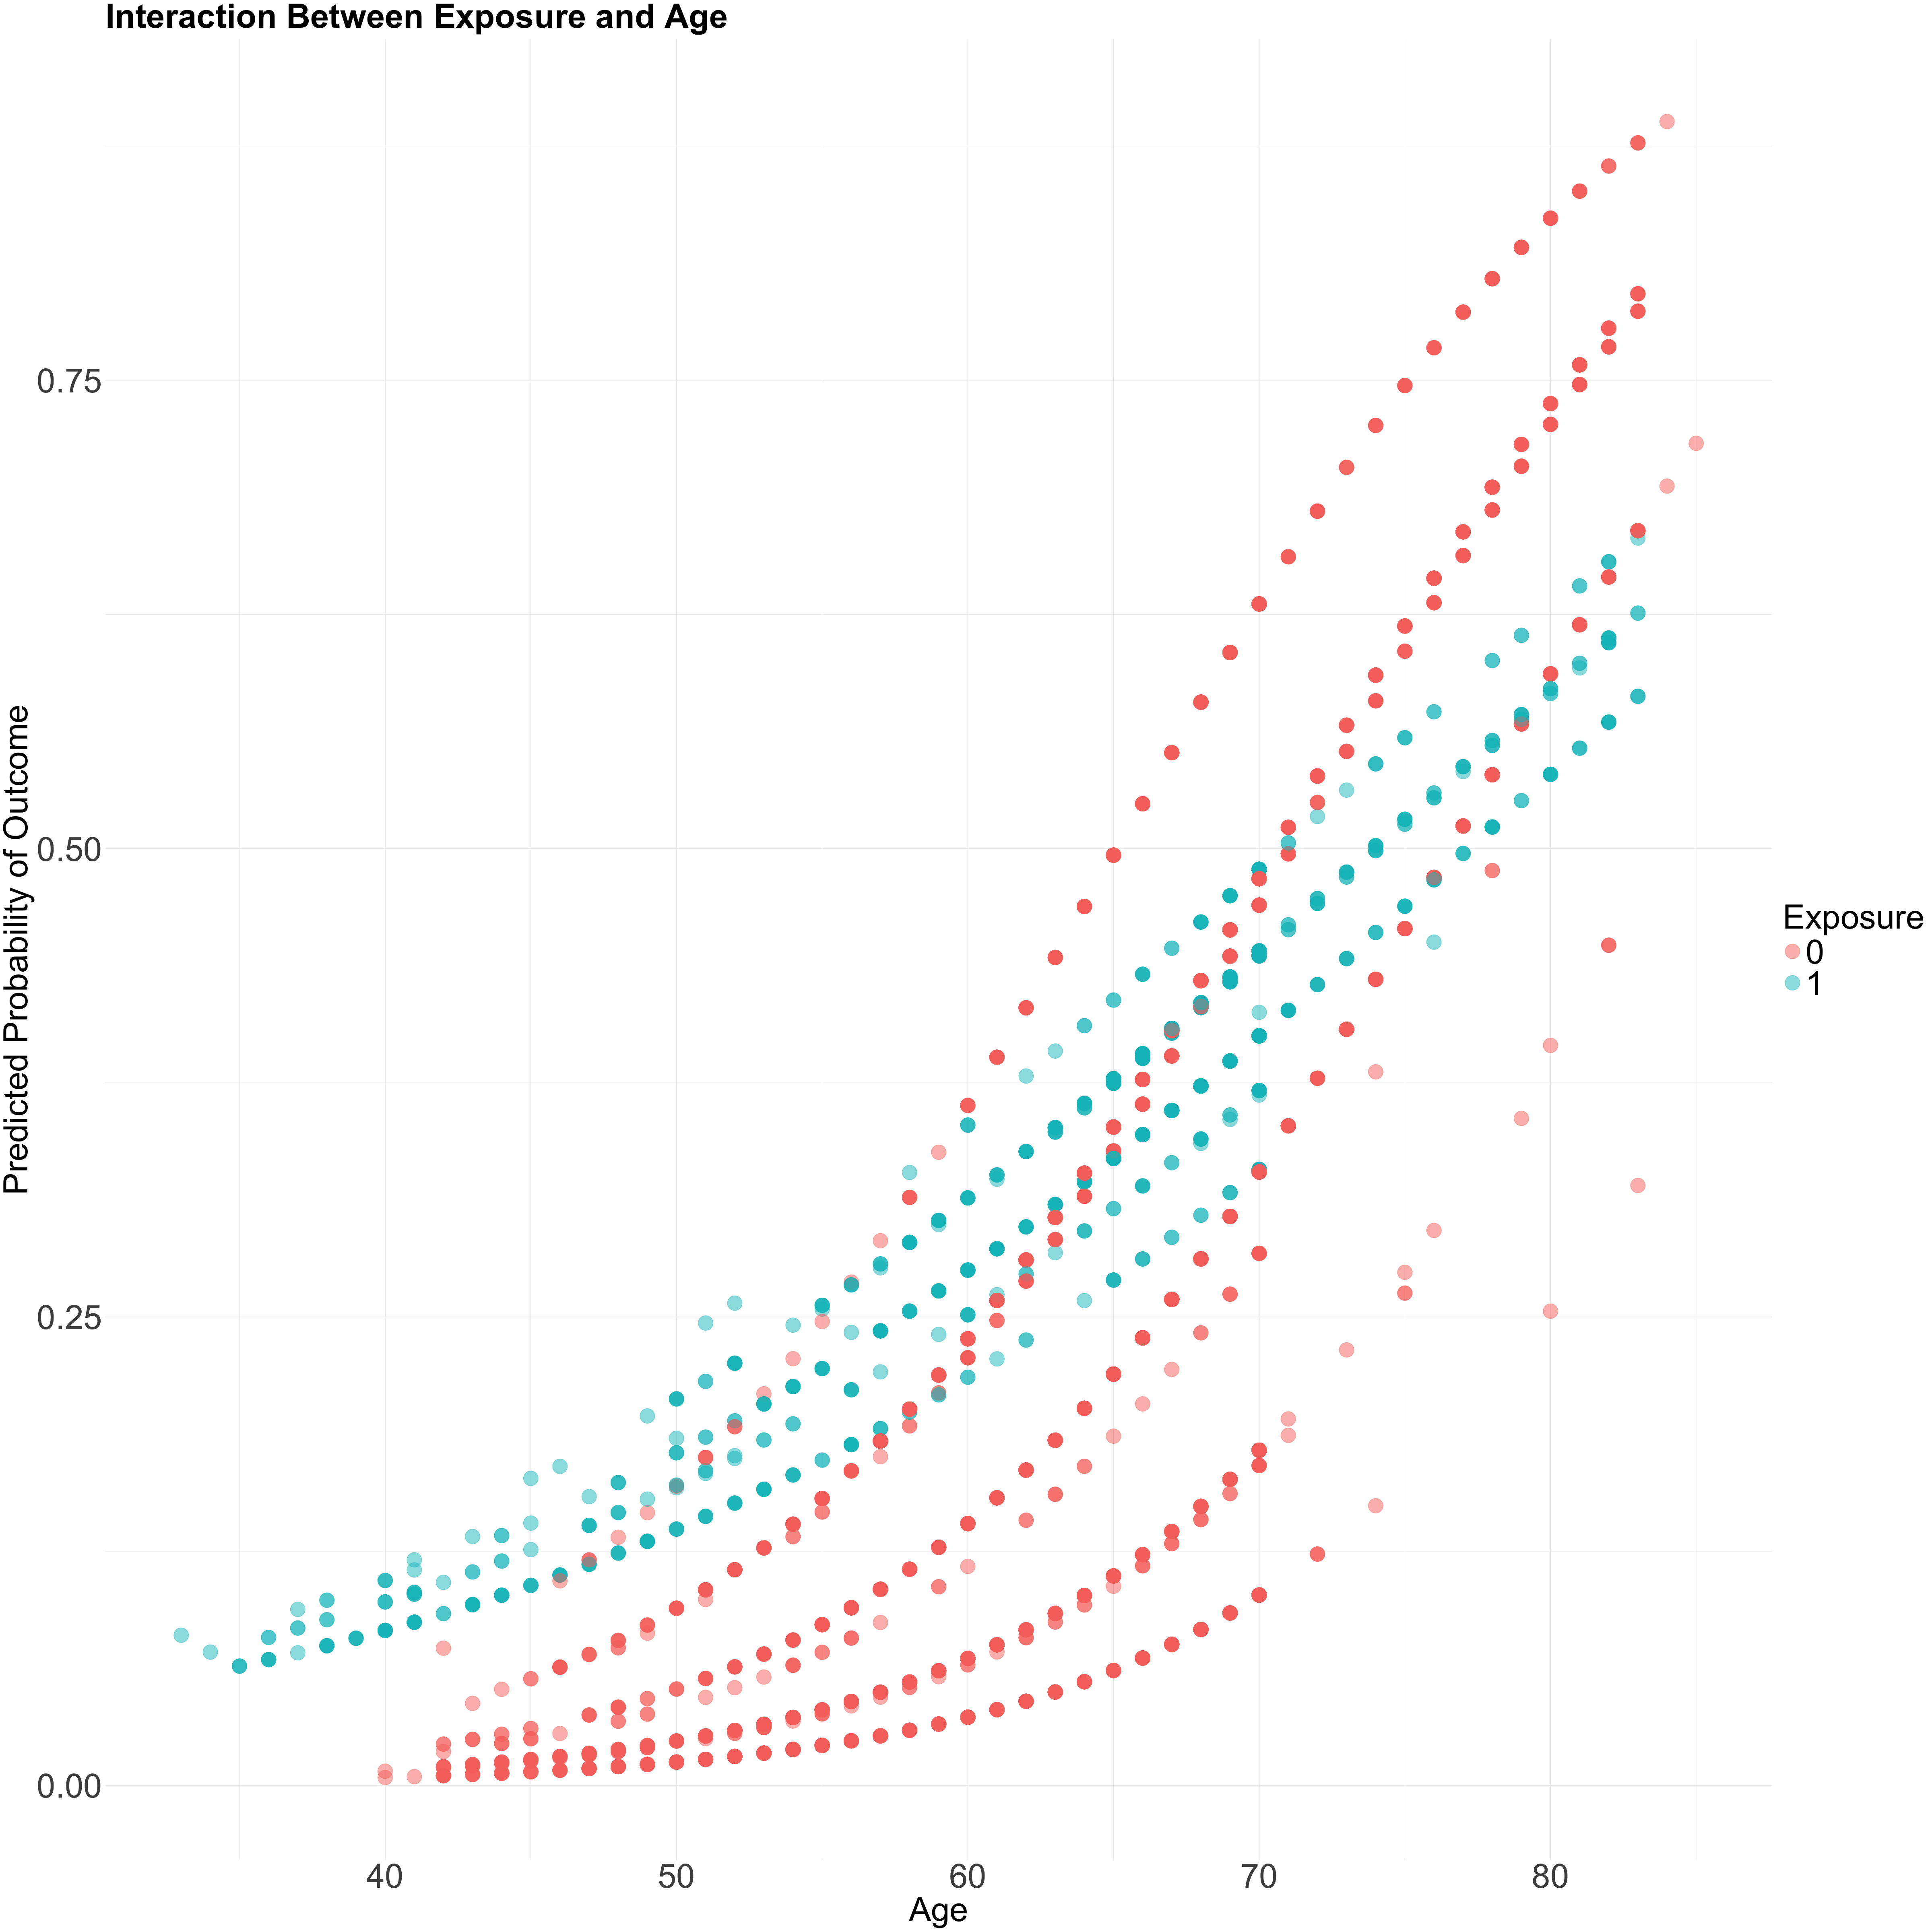

In [102]:
# Predict probabilities
Df_regression_unique$predicted_prob <- predict(interaction_model3, type = "response")

# Plot interaction effect of Age as scatterplot
ggplot(Df_regression_unique, aes(x = `age`, y = predicted_prob, color = as.factor(statin))) +
  geom_point(size = 10, alpha = 0.5) +  # Scatterplot points with custom size and transparency
  labs(title = "Interaction Between Exposure and Age",
       x = "Age",
       y = "Predicted Probability of Outcome",
       color = "Exposure") +
  theme_minimal()+  theme(
    plot.title = element_text(size = 50, face = "bold"),   # Title text size
    axis.title.x = element_text(size = 50),               # X-axis title size
    axis.title.y = element_text(size = 50),               # Y-axis title size
    axis.text.x = element_text(size = 50),                # X-axis tick label size
    axis.text.y = element_text(size = 50),                # Y-axis tick label size
    legend.title = element_text(size = 50),               # Legend title size
    legend.text = element_text(size = 50),                # Legend text size
    strip.text = element_text(size = 50, face = "bold")   # Facet label size
  )

ggsave("Interaction_Between_Exposure_and_Age.png", plot = last_plot(), width = 10, height = 8, dpi = 300)

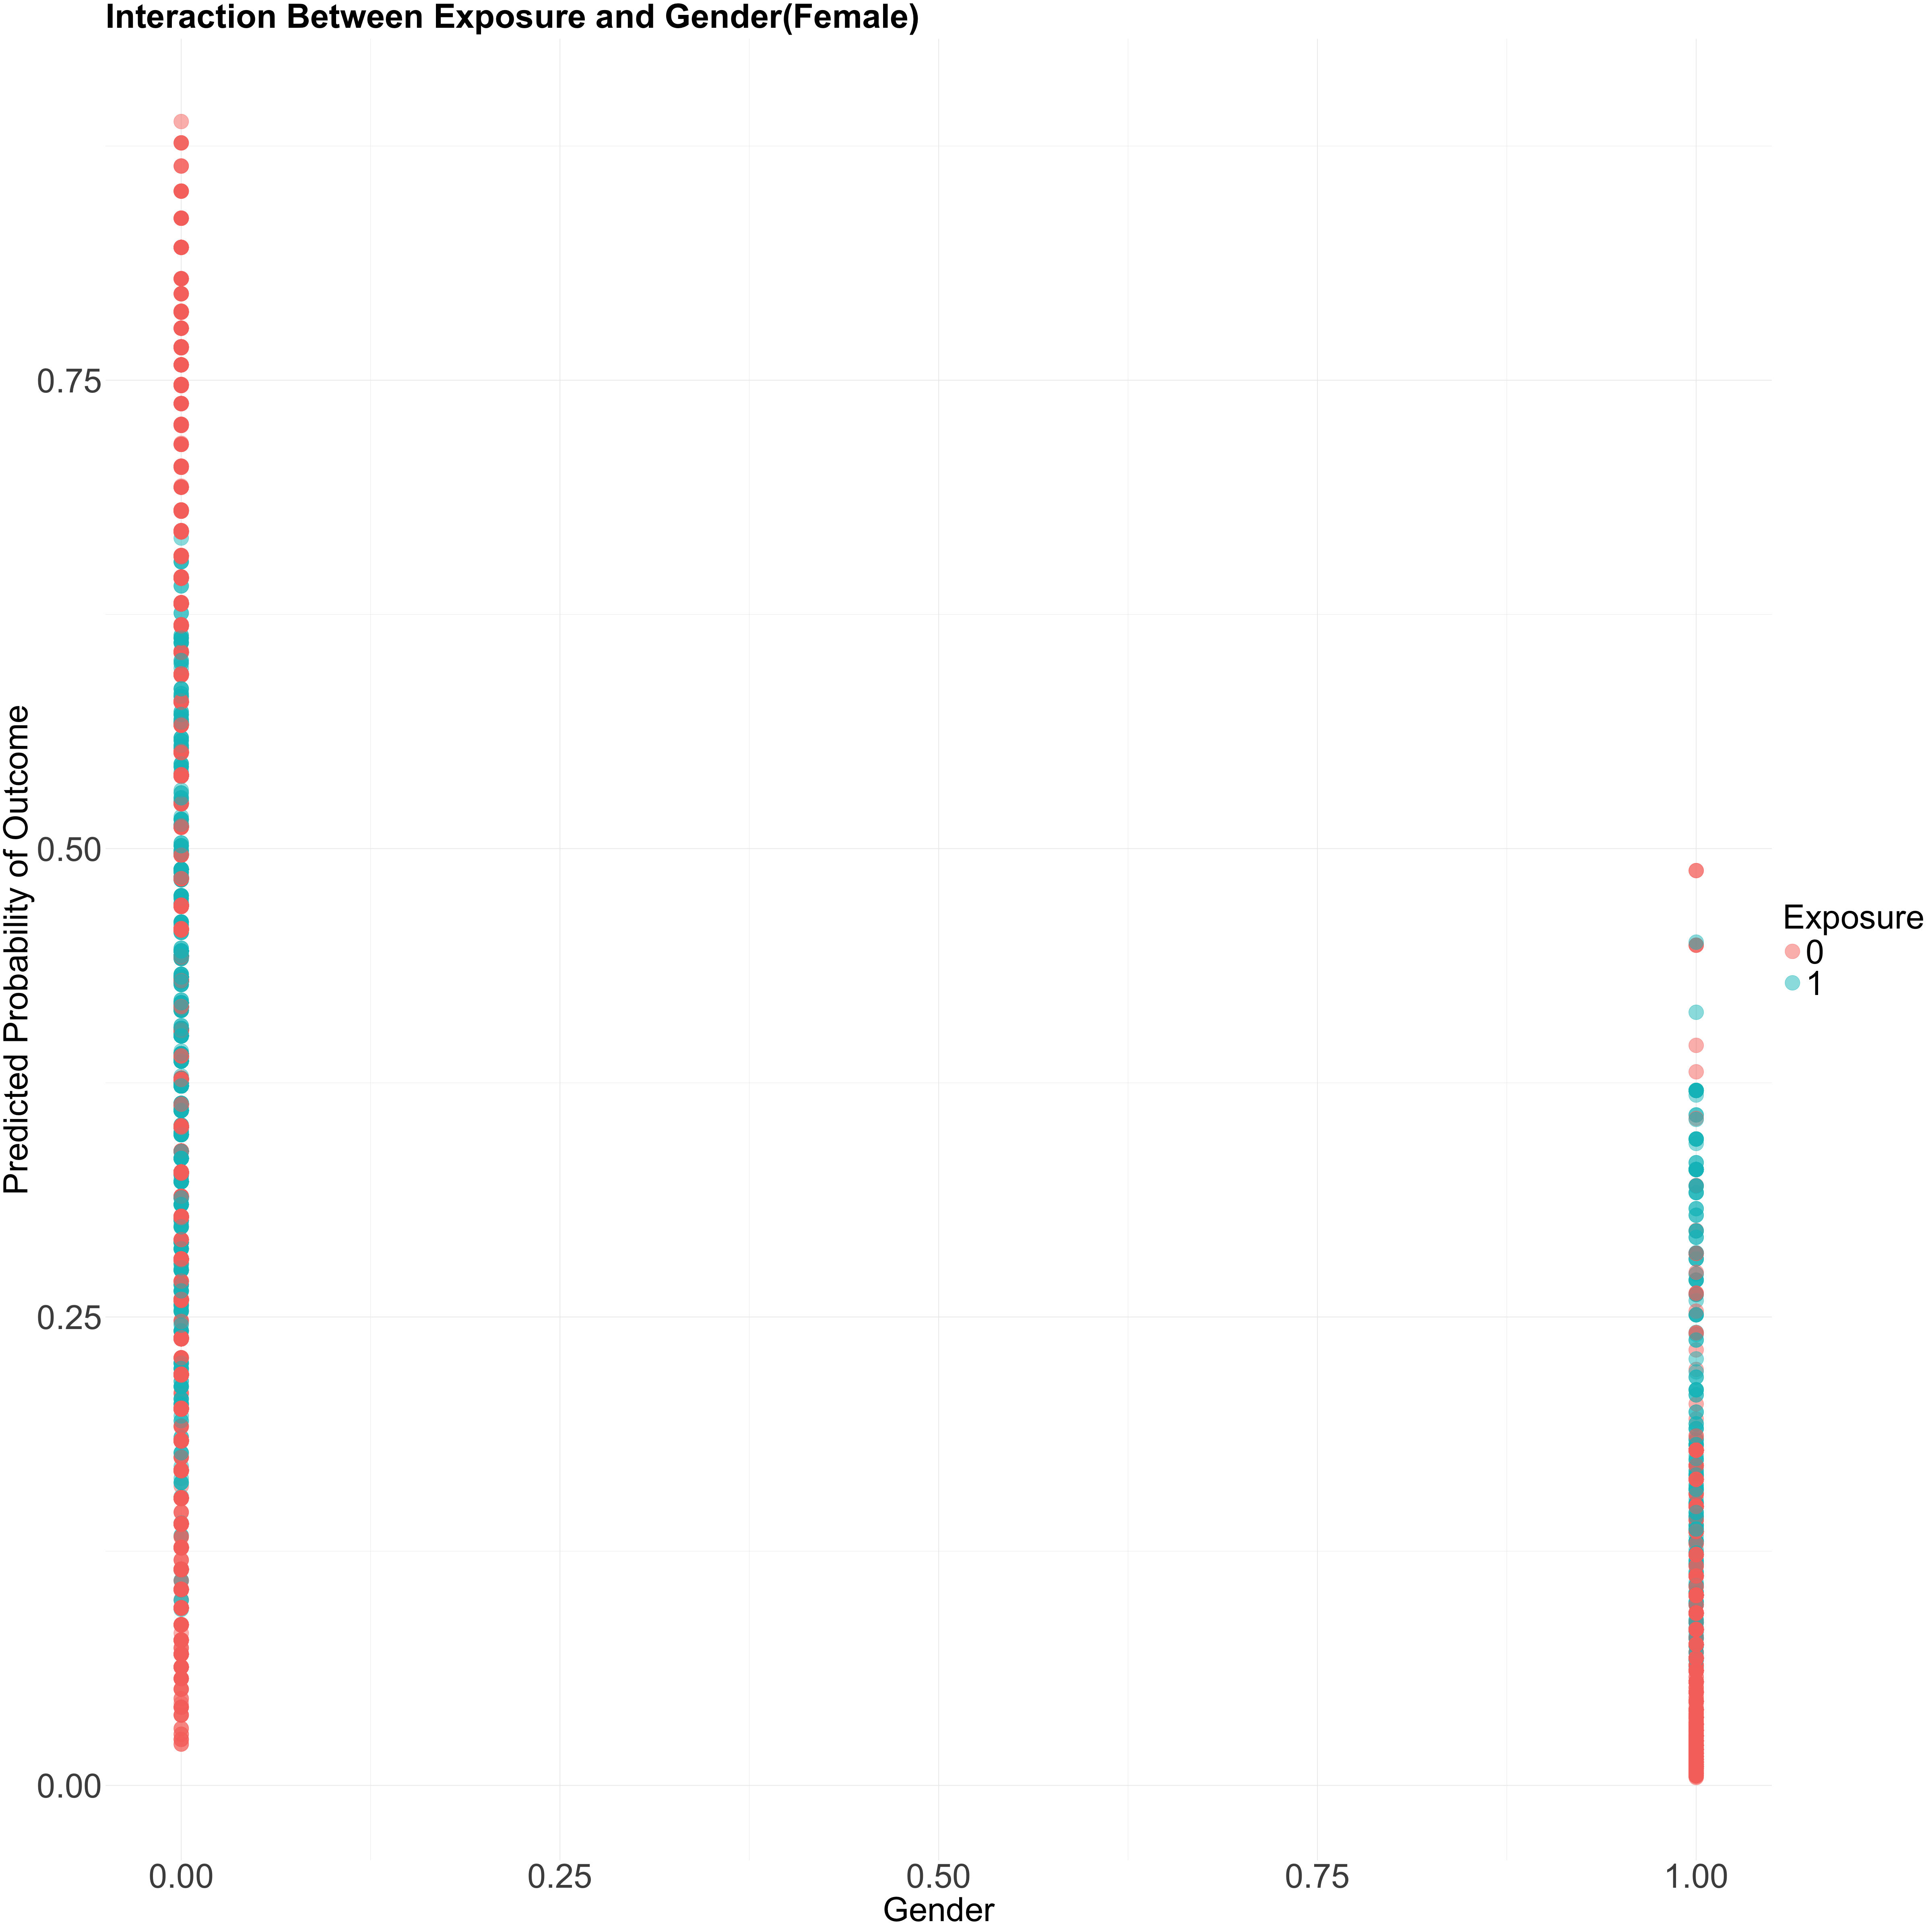

In [103]:
# Predict probabilities
Df_regression_unique$predicted_prob <- predict(interaction_model3, type = "response")

# Plot interaction effect of Age as scatterplot
ggplot(Df_regression_unique, aes(x = `gender_female`, y = predicted_prob, color = as.factor(statin))) +
  geom_point(size = 10, alpha = 0.5) +  # Scatterplot points with custom size and transparency
  labs(title = "Interaction Between Exposure and Gender(Female)",
       x = "Gender",
       y = "Predicted Probability of Outcome",
       color = "Exposure") +
  theme_minimal()+  theme(
    plot.title = element_text(size = 50, face = "bold"),   # Title text size
    axis.title.x = element_text(size = 50),               # X-axis title size
    axis.title.y = element_text(size = 50),               # Y-axis title size
    axis.text.x = element_text(size = 50),                # X-axis tick label size
    axis.text.y = element_text(size = 50),                # Y-axis tick label size
    legend.title = element_text(size = 50),               # Legend title size
    legend.text = element_text(size = 50),                # Legend text size
    strip.text = element_text(size = 50, face = "bold")   # Facet label size
  )

ggsave("Interaction_Between_Exposure_and_Gender_Female.png", plot = last_plot(), width = 10, height = 8, dpi = 300)

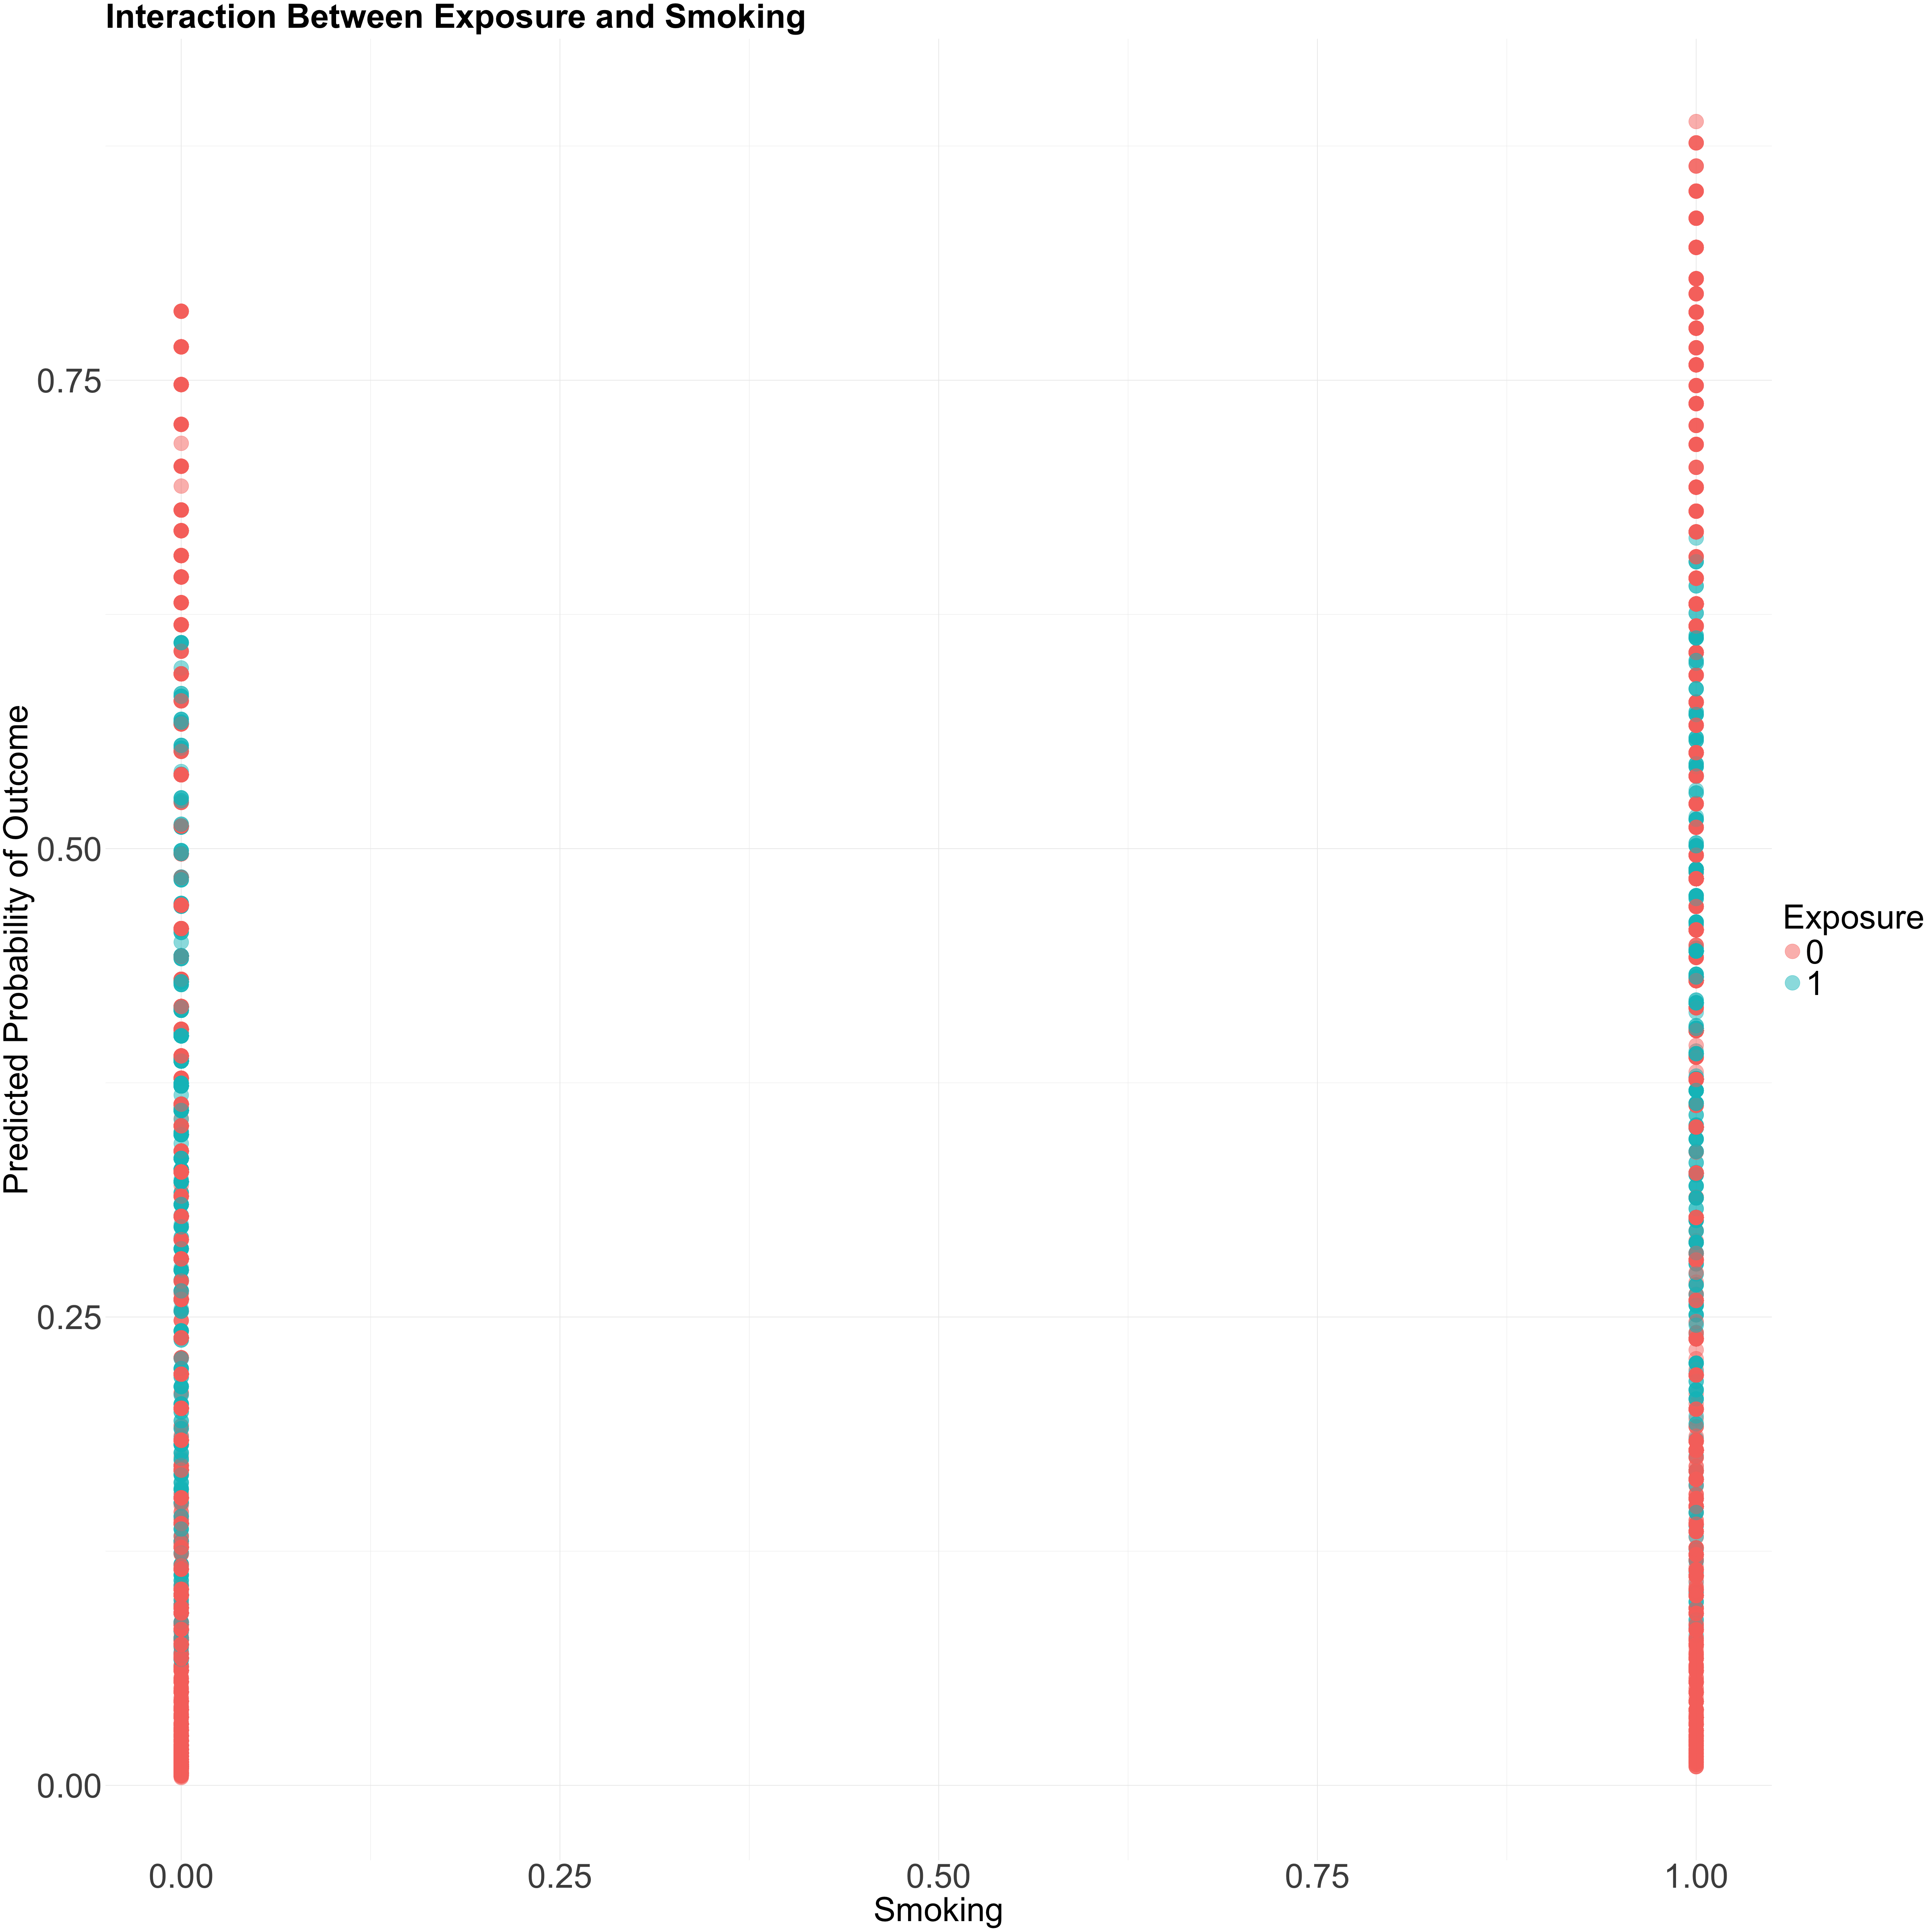

In [104]:
# Predict probabilities
Df_regression_unique$predicted_prob <- predict(interaction_model3, type = "response")

# Plot interaction effect of Age as scatterplot
ggplot(Df_regression_unique, aes(x = `smoking_status`, y = predicted_prob, color = as.factor(statin))) +
  geom_point(size = 10, alpha = 0.5) +  # Scatterplot points with custom size and transparency
  labs(title = "Interaction Between Exposure and Smoking",
       x = "Smoking",
       y = "Predicted Probability of Outcome",
       color = "Exposure") +
  theme_minimal()+  theme(
    plot.title = element_text(size = 50, face = "bold"),   # Title text size
    axis.title.x = element_text(size = 50),               # X-axis title size
    axis.title.y = element_text(size = 50),               # Y-axis title size
    axis.text.x = element_text(size = 50),                # X-axis tick label size
    axis.text.y = element_text(size = 50),                # Y-axis tick label size
    legend.title = element_text(size = 50),               # Legend title size
    legend.text = element_text(size = 50),                # Legend text size
    strip.text = element_text(size = 50, face = "bold")   # Facet label size
  )
ggsave("Interaction_Between_Exposure_and_Smoking.png", plot = last_plot(), width = 10, height = 8, dpi = 300)

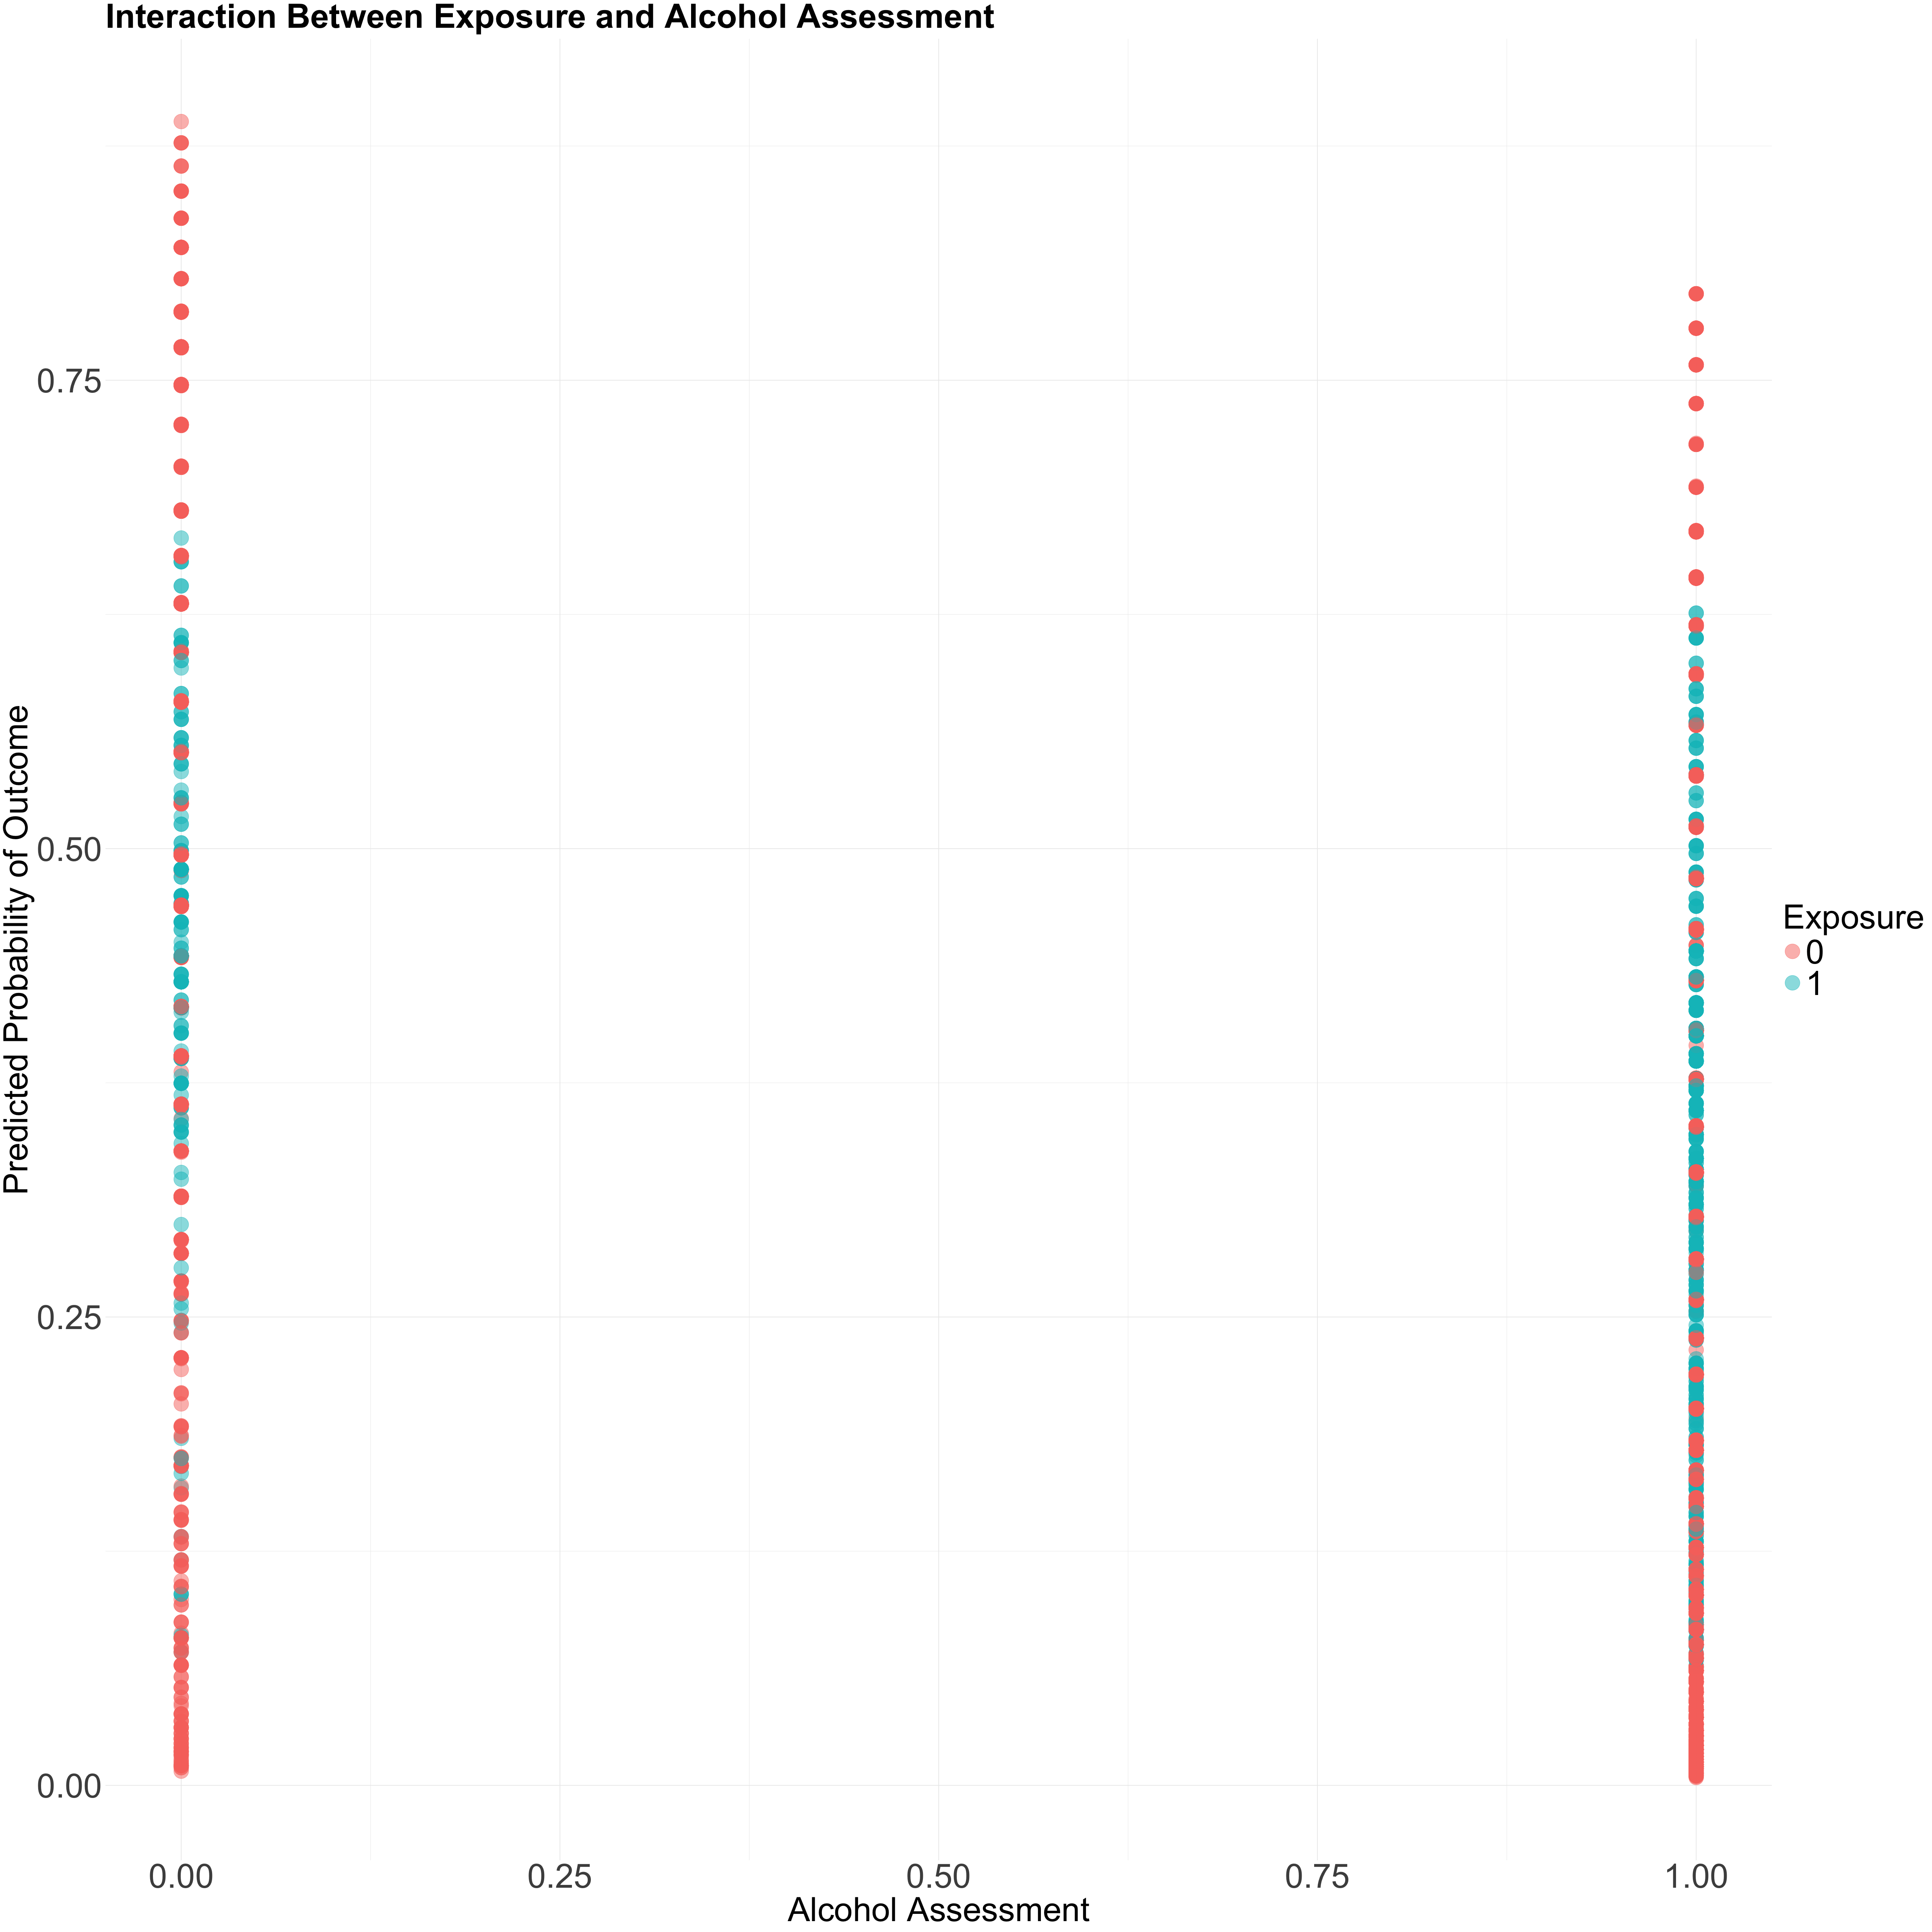

In [106]:
# Predict probabilities
Df_regression_unique$predicted_prob <- predict(interaction_model3, type = "response")

# Plot interaction effect of Age as scatterplot
ggplot(Df_regression_unique, aes(x = `alcohol_assessment`, y = predicted_prob, color = as.factor(statin))) +
  geom_point(size = 10, alpha = 0.5) +  # Scatterplot points with custom size and transparency
  labs(title = "Interaction Between Exposure and Alcohol Assessment",
       x = "Alcohol Assessment",
       y = "Predicted Probability of Outcome",
       color = "Exposure") +
  theme_minimal()+  theme(
    plot.title = element_text(size = 50, face = "bold"),   # Title text size
    axis.title.x = element_text(size = 50),               # X-axis title size
    axis.title.y = element_text(size = 50),               # Y-axis title size
    axis.text.x = element_text(size = 50),                # X-axis tick label size
    axis.text.y = element_text(size = 50),                # Y-axis tick label size
    legend.title = element_text(size = 50),               # Legend title size
    legend.text = element_text(size = 50),                # Legend text size
    strip.text = element_text(size = 50, face = "bold")   # Facet label size
  )

ggsave("Interaction_Between_Exposure_and_Alcohol_Assessment.png", plot = last_plot(), width = 10, height = 8, dpi = 300)

### Discussion: Understanding Complex Relationships
---

Effect Modification: The interaction visualization highlights whether the relationship between Exposure and the outcome is modified by the features. This suggests targeted interventions for specific subgroups.

# Question 5: Checking Predicted Probability for Two Drugs Across Predictors
---

Investigate the predicted probabilities of the outcome for two different drugs (exposure groups) across a set of predictors. For each drug, create visualizations of how predicted probabilities vary as the predictors change.
Discuss how the relationship between predictors and the predicted probability differs for each drug and the implications of these findings for clinical decision-making.

### Step 0: Investigate Predicted Probabilities
---

Investigate the predicted probabilities of the outcome for two different drugs (exposure groups) across a set of predictors through visualization.


In [107]:
# Add predicted probabilities to the dataset
# I choosed the interaction_model because its much simpler (cleaner) than the original logistic regression model

Df_regression_unique$predicted_prob <- predict(interaction_model3, type = "response")

### Step 1: Create visualizations
---

1. Create separate visualizations for each predictor. Here are some notes to interpret the graph:

    a. Difference in trends suggest the predictors affect the outcome differently for each drug. For example, given the plot of predictor 1; if the trend for exposure=1 is steep while the trend for exposure=0 is flat, it indicates predictor strongly influences outcomes for exposure=1 but not in exposure=0.

    b. A horizontal trends indicate no interaction between exposure or predictor. Crossing trends suggest significant interaction effects.

    c. Curved trends in smoothed lines highlight potential nonlinear effects.
    
---

2. What the Trend Line Represents?

- Is a locally estimated scatterplot smoothing (LOESS) curve.

- Shows how the predicted probabilities vary as the predictor changes, averaged over local regions of the data.

- Summarizes the pattern of the relationship, helping identify nonlinear relationships or trends.

- The trend line for each drug group reflects how the effect of the predictors on the outcome differs (or does not differ) between the exposure groups.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


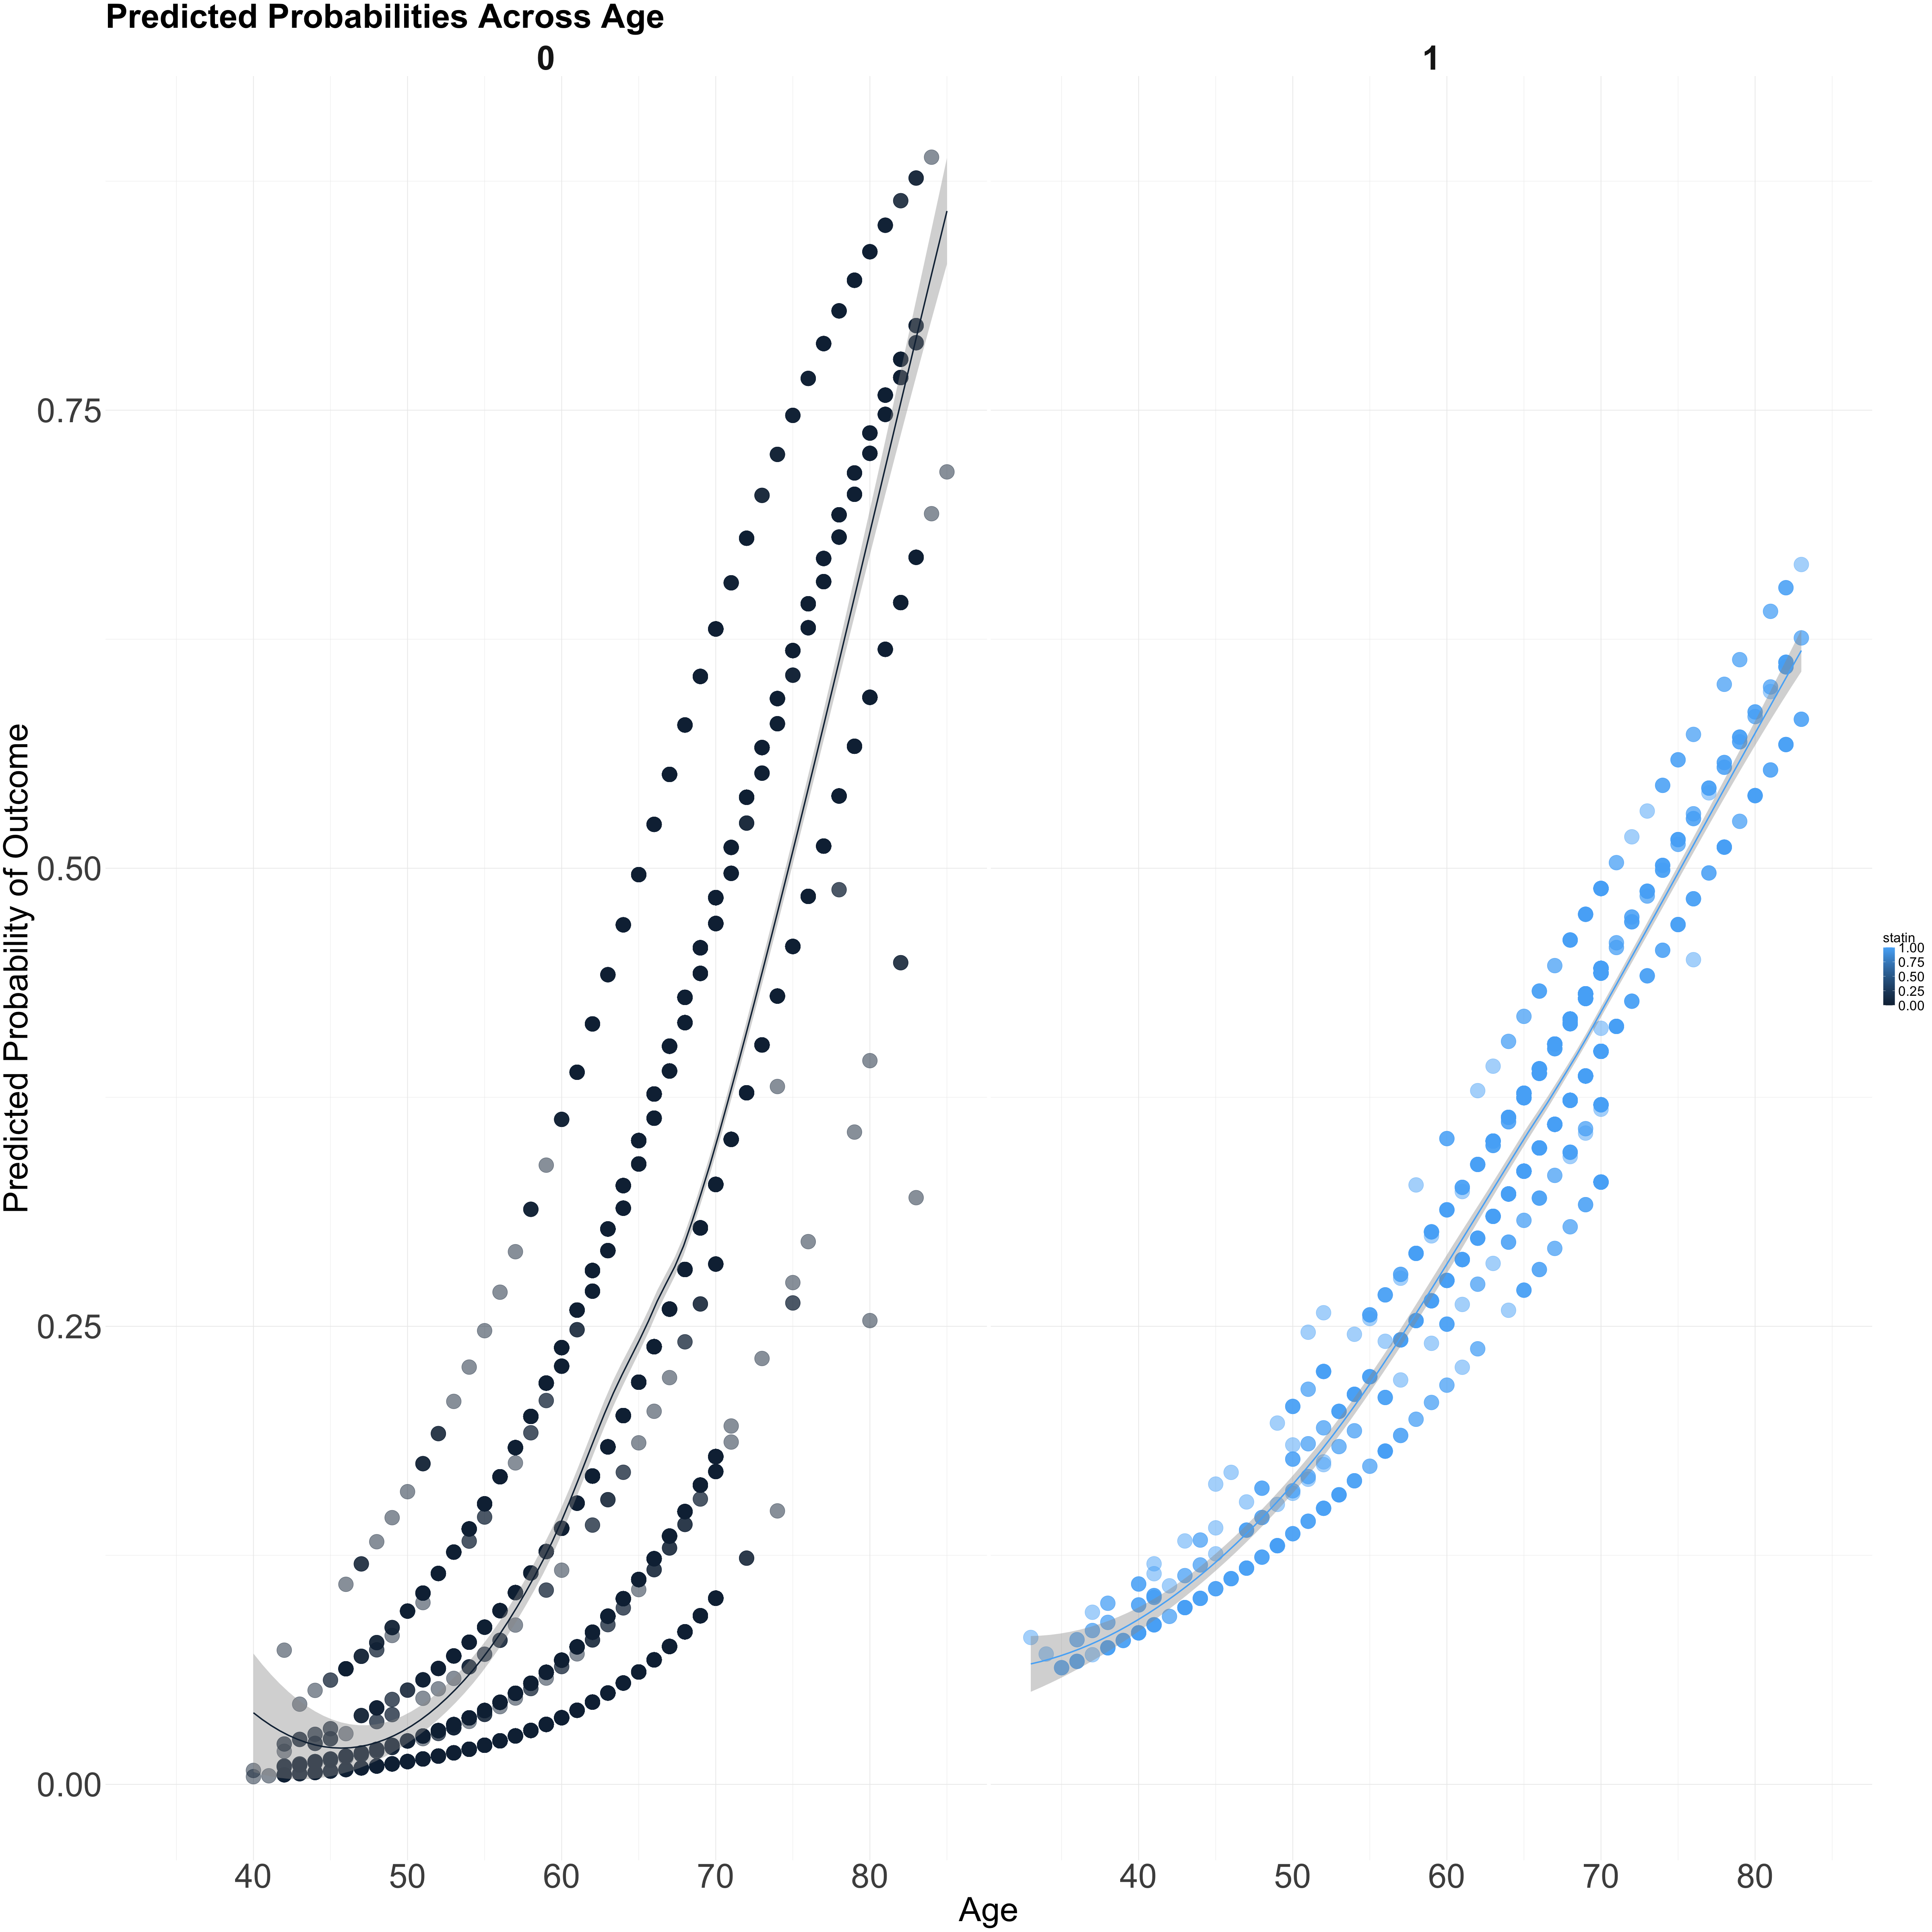

In [113]:
ggplot(Df_regression_unique, aes(x = `age`, y = predicted_prob, color = `statin`)) +
  geom_point(size = 10, alpha = 0.5) +
  geom_smooth(method = "loess", se = TRUE) +
  facet_wrap(~ `statin`) +  # Create separate plots for each drug
  labs(title = "Predicted Probabilities Across Age",
       x = "Age",
       y = "Predicted Probability of Outcome") +
  theme_minimal()+theme(
    plot.title = element_text(size = 50, face = "bold"),   # Title text size
    axis.title.x = element_text(size = 50),               # X-axis title size
    axis.title.y = element_text(size = 50),               # Y-axis title size
    axis.text.x = element_text(size = 50),                # X-axis tick label size
    axis.text.y = element_text(size = 50),                # Y-axis tick label size
    legend.title = element_text(size = 20),               # Legend title size
    legend.text = element_text(size = 20),                # Legend text size
    strip.text = element_text(size = 50, face = "bold")   # Facet label size
  )

ggsave("Predicted_Probabilities_Across_Age.png", plot = last_plot(), width = 10, height = 8, dpi = 300)

#### Interpretation:

- The plot shown above indicates that C-424144002 influences the outcome in both exposure, the curved trend also indicates the presence of a non-linear effects of the predictor.

- The plot in Exposure = 0 is much steeper than Exposure = 1 suggesting that C-424144002 may strongly influences outcomes for exposure=0 but not in exposure=1.

`geom_smooth()` using formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 1.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  3.0809e-28”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1.01”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“pseudoinverse used at -0.005”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“neighborhood radius 1.005”
Warning message in predLoess(object$y

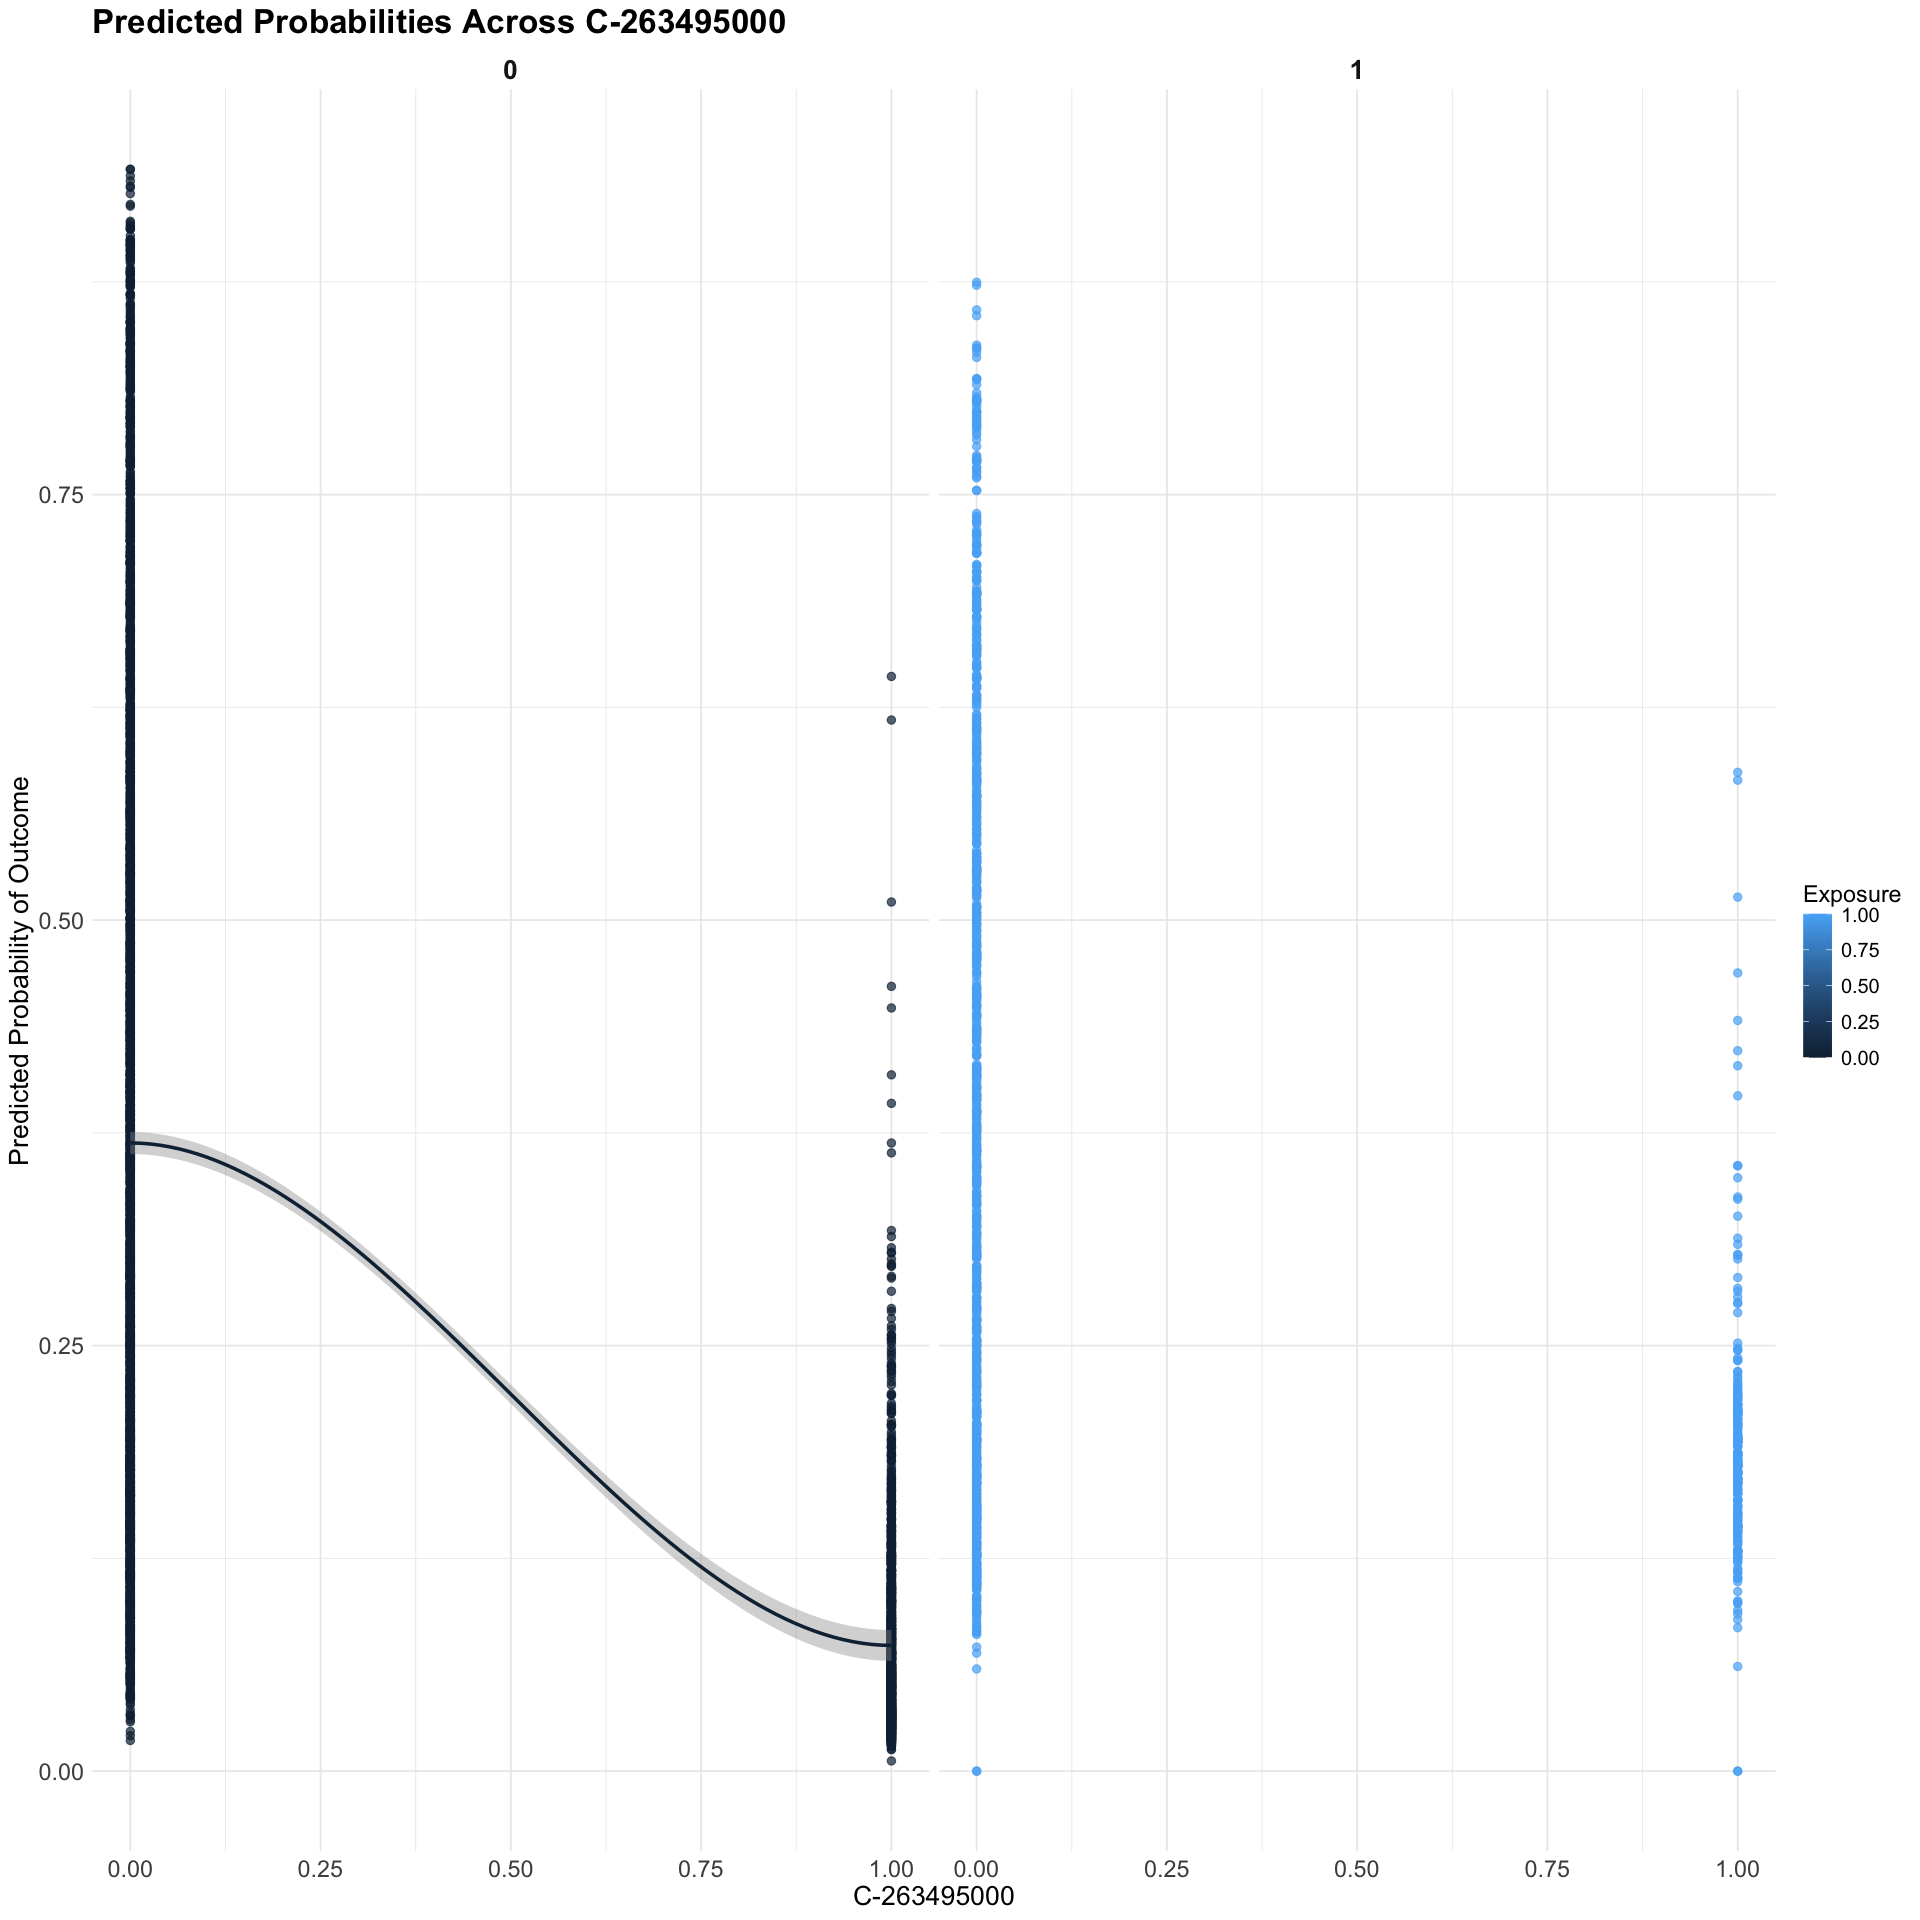

In [266]:
ggplot(Df_regression_unique, aes(x = `C-263495000`, y = predicted_prob, color = `Exposure`)) +
  geom_point(size = 2, alpha = 0.7) +
  geom_smooth(method = "loess", se = TRUE) +
  facet_wrap(~ `Exposure`) +  # Create separate plots for each drug
  labs(title = "Predicted Probabilities Across C-263495000",
       x = "C-263495000",
       y = "Predicted Probability of Outcome") +
  theme_minimal()+
  theme(
    plot.title = element_text(size = 20, face = "bold"),   # Title text size
    axis.title.x = element_text(size = 16),               # X-axis title size
    axis.title.y = element_text(size = 16),               # Y-axis title size
    axis.text.x = element_text(size = 14),                # X-axis tick label size
    axis.text.y = element_text(size = 14),                # Y-axis tick label size
    legend.title = element_text(size = 14),               # Legend title size
    legend.text = element_text(size = 12),                # Legend text size
    strip.text = element_text(size = 16, face = "bold")   # Facet label size
  )

ggsave("Predicted_Probabilities_Across_C_263495000.png", plot = last_plot(), width = 10, height = 8, dpi = 300)

#### Interpretation:

- The plot shown above indicates that C-263495000 influences the outcome in exposure = 0 but not in exposure = 1. 

- The curved trend also indicates the presence of a non-linear effects of the predictor.

`geom_smooth()` using formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 1.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  3.2196e-29”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 1.01”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“pseudoinverse used at -0.005”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“neighborhood radius 1.005”
Warning message in predLoess(object$y

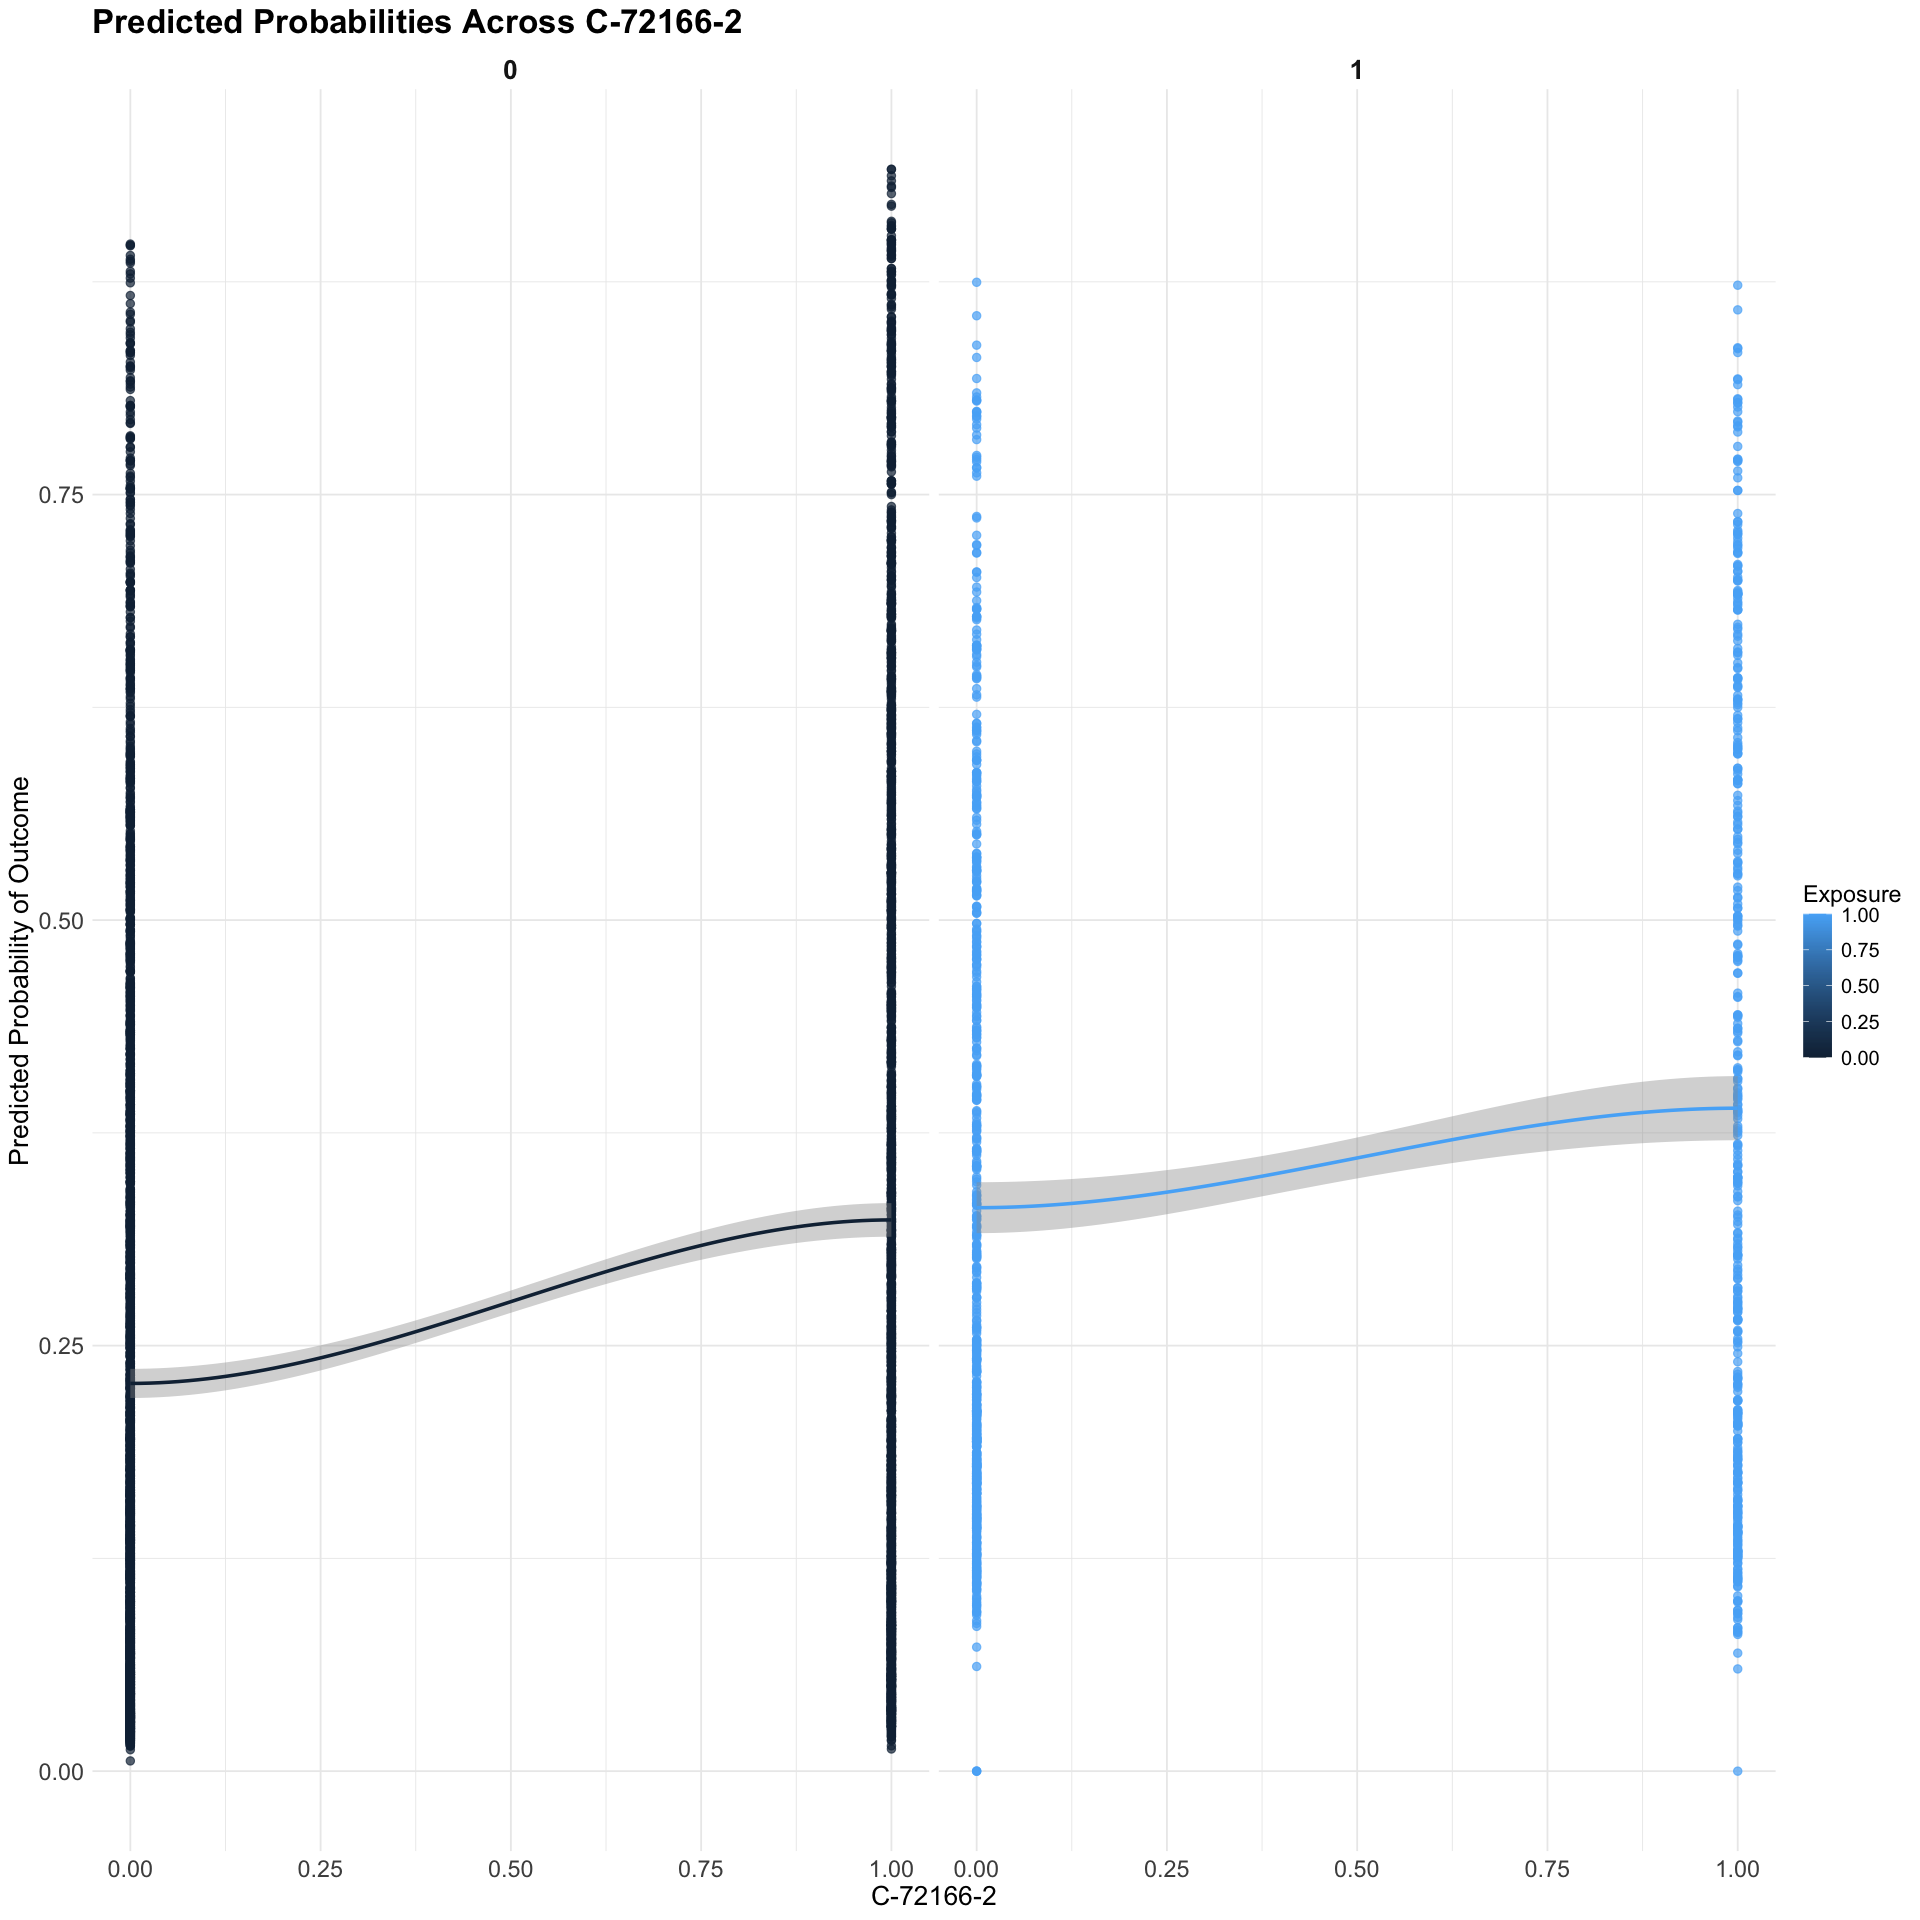

In [267]:
ggplot(Df_regression_unique, aes(x = `C-72166-2`, y = predicted_prob, color = `Exposure`)) +
  geom_point(size = 2, alpha = 0.7) +
  geom_smooth(method = "loess", se = TRUE) +
  facet_wrap(~ `Exposure`) +  # Create separate plots for each drug
  labs(title = "Predicted Probabilities Across C-72166-2",
       x = "C-72166-2",
       y = "Predicted Probability of Outcome") +
  theme_minimal()+
  theme(
    plot.title = element_text(size = 20, face = "bold"),   # Title text size
    axis.title.x = element_text(size = 16),               # X-axis title size
    axis.title.y = element_text(size = 16),               # Y-axis title size
    axis.text.x = element_text(size = 14),                # X-axis tick label size
    axis.text.y = element_text(size = 14),                # Y-axis tick label size
    legend.title = element_text(size = 14),               # Legend title size
    legend.text = element_text(size = 12),                # Legend text size
    strip.text = element_text(size = 16, face = "bold")   # Facet label size
  )

ggsave("Predicted_Probabilities_Across_C_72166_2.png", plot = last_plot(), width = 10, height = 8, dpi = 300)

#### Interpretation:

- The plot shown above indicates that C-72166-2 influences the outcome in both exposure, the curved trend also indicates the presence of a non-linear effects of the predictor.

- The plot in Exposure = 0 is much steeper than Exposure = 1 suggesting that C-72166-2 may strongly influences outcomes for exposure=1 but not in exposure=0.

`geom_smooth()` using formula = 'y ~ x'
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -0.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 1.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  2.6813e-29”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“at  1.005”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“radius  2.5e-05”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“all data on boundary of neighborhood. make span bigger”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 2.5e-05”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, 

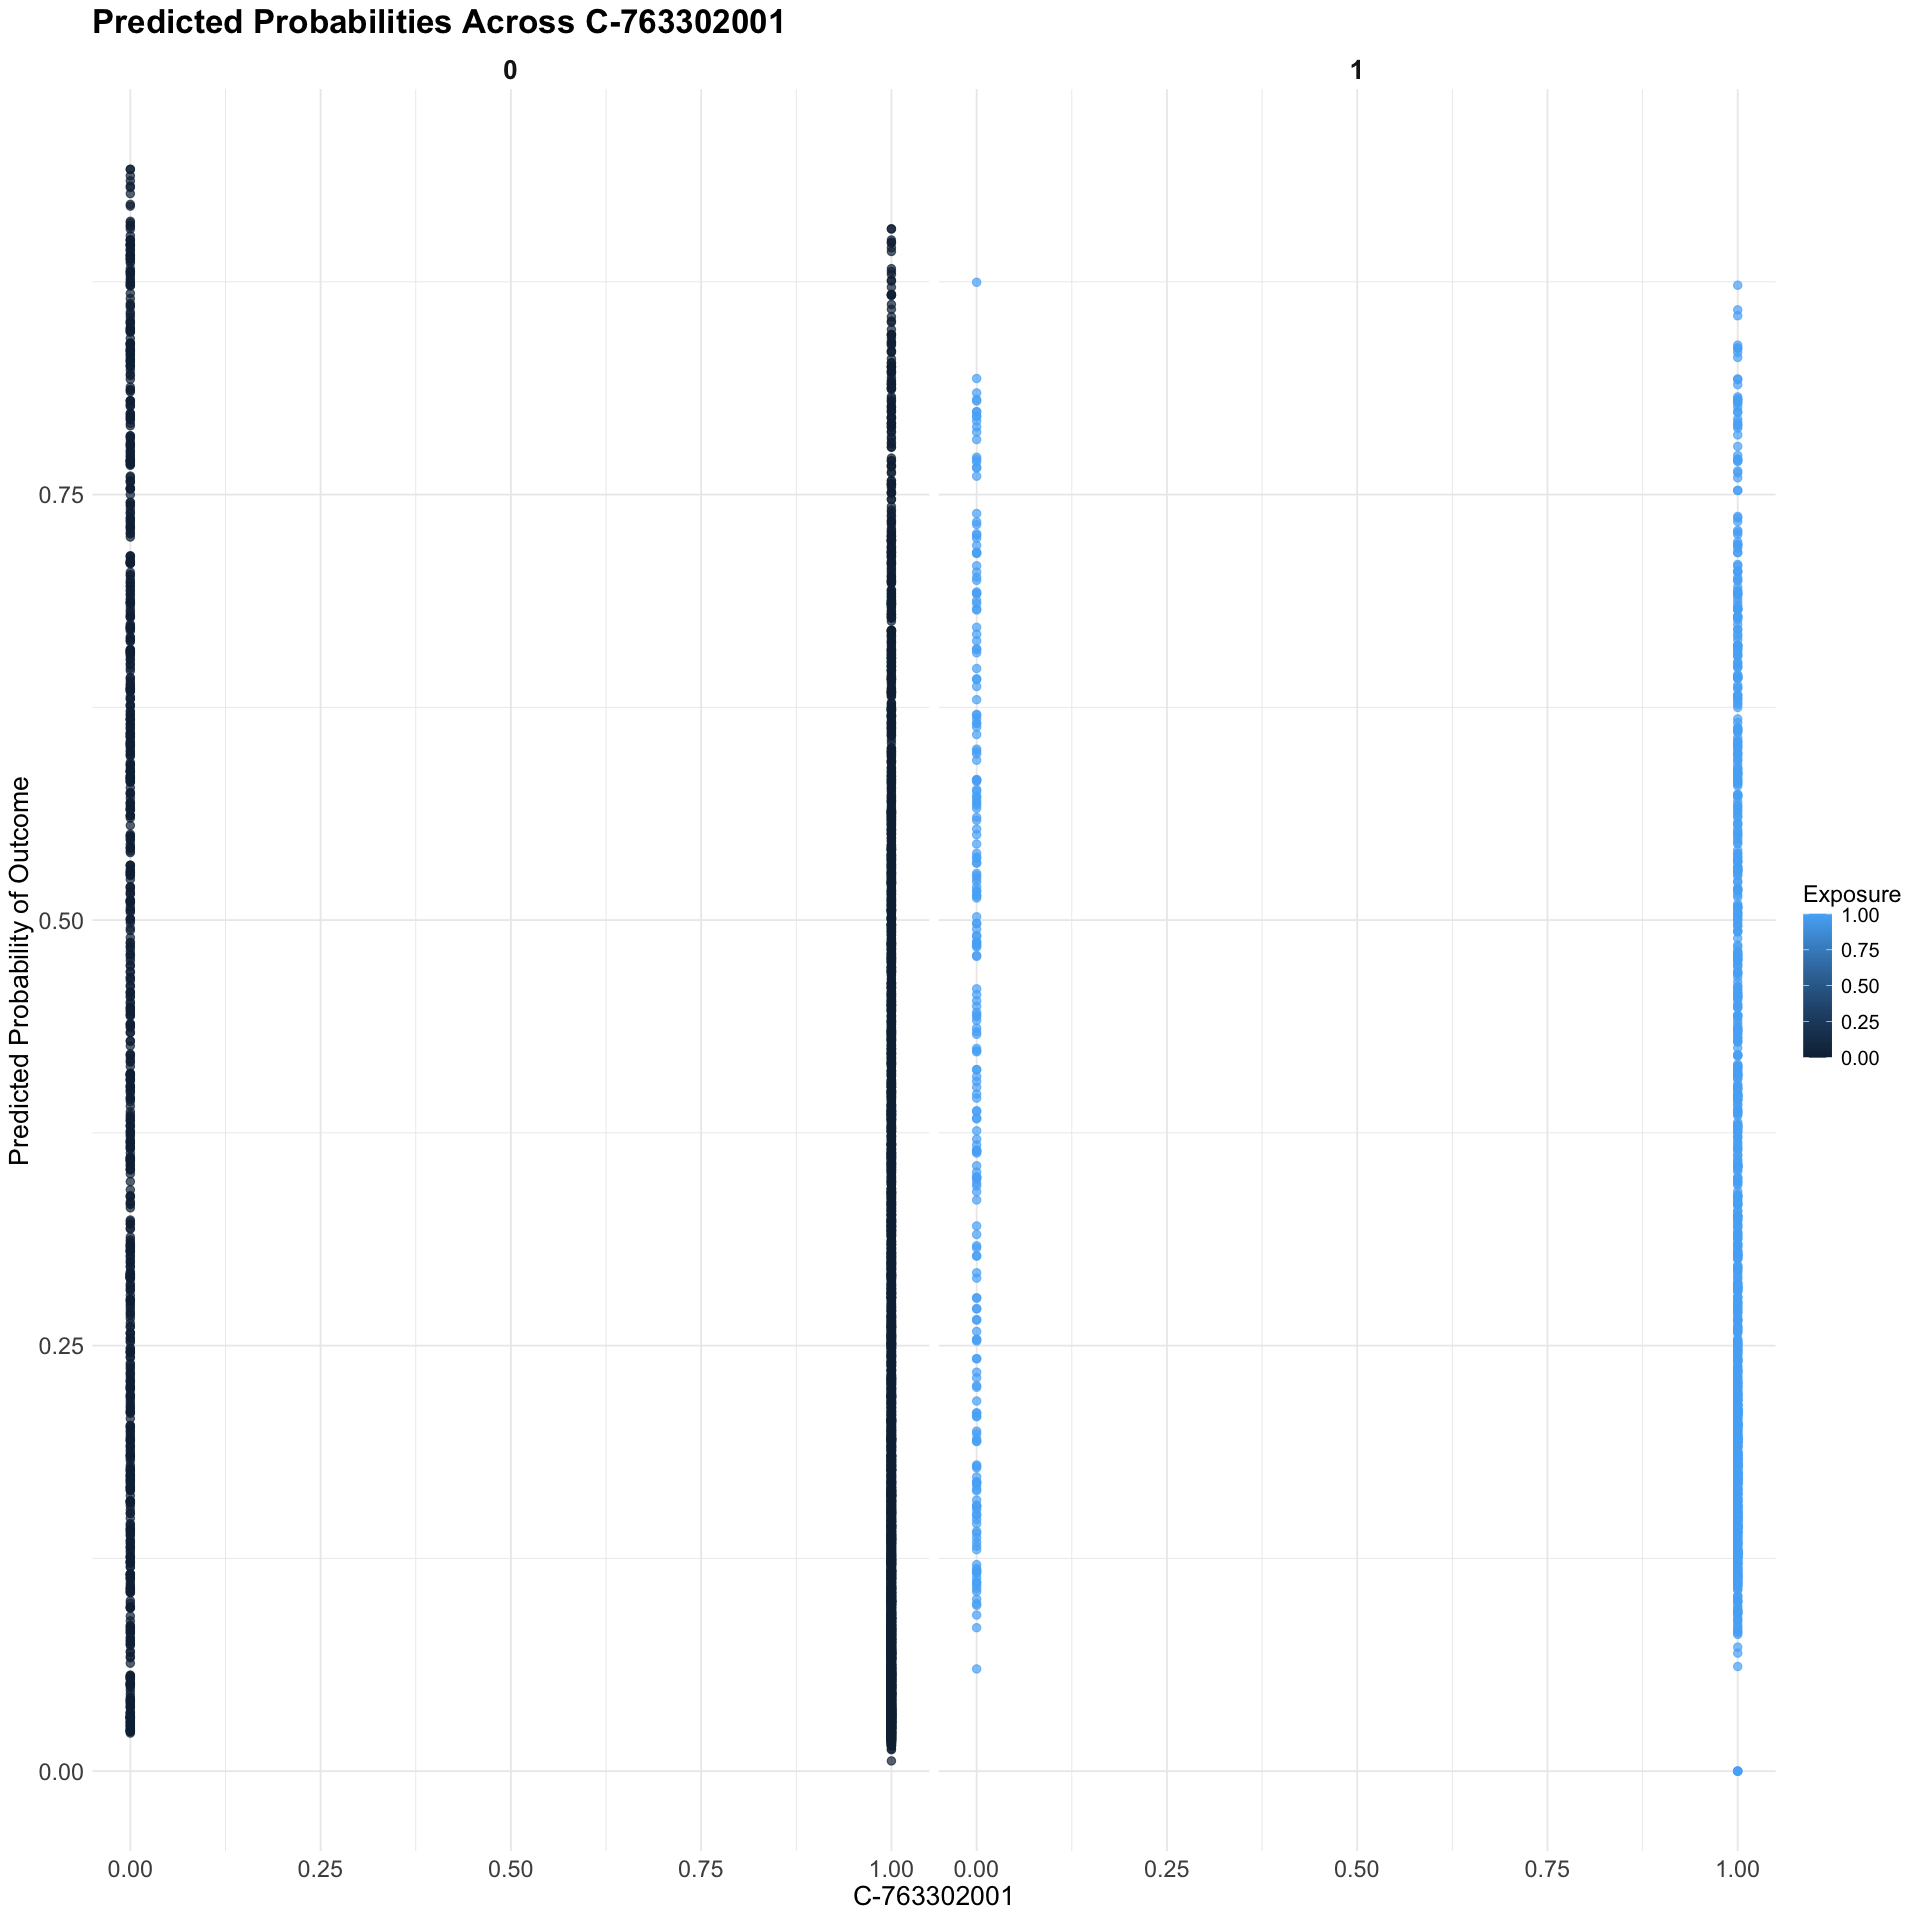

In [268]:
ggplot(Df_regression_unique, aes(x = `C-763302001`, y = predicted_prob, color = `Exposure`)) +
  geom_point(size = 2, alpha = 0.7) +
  geom_smooth(method = "loess", se = TRUE) +
  facet_wrap(~ `Exposure`) +  # Create separate plots for each drug
  labs(title = "Predicted Probabilities Across C-763302001",
       x = "C-763302001",
       y = "Predicted Probability of Outcome") +
  theme_minimal()+
  theme(
    plot.title = element_text(size = 20, face = "bold"),   # Title text size
    axis.title.x = element_text(size = 16),               # X-axis title size
    axis.title.y = element_text(size = 16),               # Y-axis title size
    axis.text.x = element_text(size = 14),                # X-axis tick label size
    axis.text.y = element_text(size = 14),                # Y-axis tick label size
    legend.title = element_text(size = 14),               # Legend title size
    legend.text = element_text(size = 12),                # Legend text size
    strip.text = element_text(size = 16, face = "bold")   # Facet label size
  )

ggsave("Predicted_Probabilities_Across_C_763302001.png", plot = last_plot(), width = 10, height = 8, dpi = 300)

#### Interpretation:
---

- The plot in Exposure = 0 is much steeper than Exposure = 1 suggesting that C-72166-2 may strongly influences outcomes for exposure=1 but not in exposure=0.

- There is no trend line, indicating that the relationship between C-763302001 and the outcome does not depend on the exposure group. In other words, there is no significant interaction effect between the exposure and C-72166-2.

- What Parallel(or Absence) of Trends Indicate?
    
    a. Independent Effects:

        - The effect of the predictor on the outcome is consistent across the exposure groups.
        
        - For example, if age affects the probability of recovery similarly for exposure=1 and exposure=0, the age-outcome relationship will have parallel trends across the two groups.
    
    b. No Effect Modification:

        - There is no effect modification, meaning that the predictor’s influence on the outcome does not change based on the exposure.
        
        - The predictor (e.g., age) influences the outcome (e.g., recovery) in the same way, regardless of which drug is administered.
    
    c. Additive Effects:

        - The effects of the predictor and the drug are additive rather than multiplicative. 
        
        For example:
        
            - The predictor might increase the odds of the outcome by the same amount for both exposure.

            - No additional variability in the effect is explained by the combination of the predictor and the exposure.